<a href="https://colab.research.google.com/github/Nouran-Khallaf/Arabic-Readability-Corpus/blob/main/NoteBooks/sentence_alignment_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sentence Alignment for Parallel Corpus Creation

In this notebook, we will explore multiple ways to calculate sentence similarity for aligning sentences between two corpora. Specifically, we will work with Vikidia and Wikipedia datasets to create a parallel corpus.

## Methods for Similarity Calculation:

1. **TF-IDF + Cosine Similarity**
    - Use the Term Frequency-Inverse Document Frequency (TF-IDF) representation of the sentences followed by cosine similarity to measure how close two sentences are.

2. **Word2Vec + Cosine Similarity**
    - Use word embeddings (Word2Vec) to create vector representations of the sentences and compute cosine similarity between the resulting sentence vectors.

3. **SBERT (Sentence-BERT)**
    - Sentence-BERT is a variation of BERT that computes dense vector representations for sentences. Cosine similarity between SBERT embeddings is used to find the closest sentence pairs.

4. **Multilingual Transformers (e.g., XLM-Roberta)**
    - Multilingual models like XLM-Roberta can encode sentences from different languages into a shared vector space. Cosine similarity is used to compare these embeddings.

5. **BLEU Score**
    - BLEU is a popular metric for evaluating machine translation systems. It can also be used to measure the similarity between two sentences based on n-gram overlap.

6. **Jaccard Similarity**
    - Jaccard similarity measures the overlap between two sets, which in this case are the words in each sentence. It calculates the size of the intersection divided by the size of the union of the two word sets.

7. **Translation Error Rate (TER)**
    - TER is a metric used for evaluating the number of edits needed to change one sentence into another. It is useful in sentence alignment when trying to evaluate how "noisy" a translation might be.

8. **Dynamic Time Warping (DTW)**
    - DTW is a technique that calculates an optimal match between two sequences, potentially allowing for temporal distortions. This is useful when aligning long, structured text or when the sentence order might differ.





In [ ]:
!pip install spacy gensim sentence-transformers torch nltk scikit-learn transformers
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


 SBERT model

In [ ]:
import spacy
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import re

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to clean individual sentences by removing HTML-like tags and unwanted symbols
def clean_sentence(sentence):
    sentence = re.sub(r'<[^>]+>', '', sentence)  # Remove everything within <>
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove extra whitespace
    return sentence.strip()

# Function to split text into sentences using SpaCy
def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    return sentences

# Read, split, and clean the sentences while filtering out invalid ones
def read_clean_split_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    # Split into sentences
    sentences = split_into_sentences(text)
    # Clean each sentence and filter out sentences that are empty or just tags
    cleaned_sentences = [clean_sentence(sentence) for sentence in sentences if clean_sentence(sentence)]
    return cleaned_sentences

vikidia_file_path = '/content/vikidia-en-political.ol'
wiki_file_path = '/content/vikidia-en-political.ol'

# Split and clean the sentences
vikidia_sentences = read_clean_split_file(vikidia_file_path)
wiki_sentences = read_clean_split_file(wiki_file_path)

# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode sentences
vikidia_embeddings = sbert_model.encode(vikidia_sentences, convert_to_tensor=True)
wiki_embeddings = sbert_model.encode(wiki_sentences, convert_to_tensor=True)

# Find the top 3 closest sentences for each Vikidia sentence in the Wikipedia set
closest_sentences = []
for vikidia_embedding in vikidia_embeddings:
    # Compute cosine similarities
    cosine_scores = util.pytorch_cos_sim(vikidia_embedding, wiki_embeddings)
    # Get the top 3 closest sentences from Wikipedia
    top3_idx = torch.topk(cosine_scores, 3, dim=1).indices[0].tolist()
    closest_3 = [(wiki_sentences[i], cosine_scores[0, i].item()) for i in top3_idx]
    closest_sentences.append(closest_3)

# Prepare data for CSV
csv_data = []
for i, vikidia_sentence in enumerate(vikidia_sentences):
    row = [vikidia_sentence]
    for closest, score in closest_sentences[i]:
        row.append(closest)
        row.append(score)
    csv_data.append(row)

# Define column headers
columns = ['Vikidia Sentence', 'Closest Wiki Sentence 1', 'Score 1', 'Closest Wiki Sentence 2', 'Score 2', 'Closest Wiki Sentence 3', 'Score 3']

# Create DataFrame
df = pd.DataFrame(csv_data, columns=columns)

# Save to CSV
df.to_csv('vikidia_wiki_closest_sentences_cleaned.csv', index=False)

print("Results saved to 'vikidia_wiki_closest_sentences_cleaned.csv'")


Results saved to 'vikidia_wiki_closest_sentences_cleaned.csv'


In [ ]:
# Save results to CSV
def save_to_csv(vikidia_sentences, closest_sentences, file_name):
    csv_data = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        row = [vikidia_sentence]
        for closest, score in closest_sentences[i]:
            row.append(closest)
            row.append(score)
        csv_data.append(row)

    # Define column headers
    columns = ['Vikidia Sentence', 'Closest Wiki Sentence 1', 'Score 1', 'Closest Wiki Sentence 2', 'Score 2', 'Closest Wiki Sentence 3', 'Score 3']

    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data, columns=columns)
    df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

1. **TF-IDF + Cosine Similarity**
    - Use the Term Frequency-Inverse Document Frequency (TF-IDF) representation of the sentences followed by cosine similarity to measure how close two sentences are.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

def run_tfidf_method(vikidia_sentences, wiki_sentences):
    vectorizer = TfidfVectorizer()

    # Fit the vectorizer on both Vikidia and Wikipedia sentences
    tfidf = vectorizer.fit_transform(vikidia_sentences + wiki_sentences)

    # Split the resulting matrix back into two parts
    tfidf_vikidia = tfidf[:len(vikidia_sentences)]
    tfidf_wiki = tfidf[len(vikidia_sentences):]

    # Compute cosine similarity between Vikidia and Wikipedia sentences
    similarities_tfidf = cosine_similarity(tfidf_vikidia, tfidf_wiki)

    # Find top 3 closest sentences for each Vikidia sentence
    closest_sentences_tfidf = []
    for i in range(similarities_tfidf.shape[0]):
        top3_idx = similarities_tfidf[i].argsort()[-3:][::-1]  # Top 3 closest indices
        closest_3 = [(wiki_sentences[idx], similarities_tfidf[i][idx]) for idx in top3_idx]
        closest_sentences_tfidf.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_tfidf, "vikidia_wiki_closest_sentences_tfidf.csv")

def save_to_csv(vikidia_sentences, closest_sentences, output_filename):
    # Create a DataFrame for the Vikidia sentences and their closest Wikipedia sentences
    rows = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        for j, (wiki_sentence, similarity) in enumerate(closest_sentences[i]):
            rows.append({
                "Vikidia Sentence": vikidia_sentence,
                f"Closest Wiki Sentence {j+1}": wiki_sentence,
                f"Similarity {j+1}": similarity
            })

    df = pd.DataFrame(rows)
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")


run_tfidf_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_tfidf.csv


2. **Word2Vec + Cosine Similarity**
    - Use word embeddings (Word2Vec) to create vector representations of the sentences and compute cosine similarity between the resulting sentence vectors.


In [ ]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def run_word2vec_method(vikidia_sentences, wiki_sentences):
    model = Word2Vec(sentences=[sent.split() for sent in vikidia_sentences + wiki_sentences], vector_size=100, window=5, min_count=1, workers=4)

    def get_sentence_embedding(sentence, model):
        words = sentence.split()
        word_embeddings = [model.wv[word] for word in words if word in model.wv]
        if word_embeddings:
            return np.mean(word_embeddings, axis=0)
        else:
            return np.zeros(model.vector_size)

    vikidia_embeddings = np.array([get_sentence_embedding(sent, model) for sent in vikidia_sentences])
    wiki_embeddings = np.array([get_sentence_embedding(sent, model) for sent in wiki_sentences])

    similarities_word2vec = cosine_similarity(vikidia_embeddings, wiki_embeddings)

    # Find top 3 closest sentences
    closest_sentences_word2vec = []
    for i in range(similarities_word2vec.shape[0]):
        top3_idx = similarities_word2vec[i].argsort()[-3:][::-1]  # Top 3 closest indices
        closest_3 = [(wiki_sentences[idx], similarities_word2vec[i][idx]) for idx in top3_idx]
        closest_sentences_word2vec.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_word2vec, "vikidia_wiki_closest_sentences_word2vec.csv")


run_word2vec_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_word2vec.csv



3. **SBERT (Sentence-BERT)**
    - Sentence-BERT is a variation of BERT that computes dense vector representations for sentences. Cosine similarity between SBERT embeddings is used to find the closest sentence pairs.



In [ ]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

def run_sbert_method(vikidia_sentences, wiki_sentences):
    sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Encode both Vikidia and Wikipedia sentences into embeddings
    vikidia_embeddings = sbert_model.encode(vikidia_sentences, convert_to_tensor=True)
    wiki_embeddings = sbert_model.encode(wiki_sentences, convert_to_tensor=True)

    closest_sentences_sbert = []
    for vikidia_embedding in vikidia_embeddings:
        # Compute cosine similarity between Vikidia sentence and all Wikipedia sentences
        cosine_scores = util.pytorch_cos_sim(vikidia_embedding, wiki_embeddings)

        # Determine the top-k (min between 3 or the number of available Wikipedia sentences)
        top_k = min(3, len(wiki_sentences))

        # Get the indices of the top-k closest Wikipedia sentences
        topk_idx = torch.topk(cosine_scores, top_k).indices[0].tolist()

        # Collect the closest sentences and their similarity scores
        closest_3 = [(wiki_sentences[i], cosine_scores[0, i].item()) for i in topk_idx]
        closest_sentences_sbert.append(closest_3)

    # Save results to CSV
    save_to_csv(vikidia_sentences, closest_sentences_sbert, "vikidia_wiki_closest_sentences_sbert.csv")

def save_to_csv(vikidia_sentences, closest_sentences, output_filename):
    # Create a DataFrame for the Vikidia sentences and their closest Wikipedia sentences
    rows = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        for j, (wiki_sentence, similarity) in enumerate(closest_sentences[i]):
            rows.append({
                "Vikidia Sentence": vikidia_sentence,
                f"Closest Wiki Sentence {j+1}": wiki_sentence,
                f"Similarity {j+1}": similarity
            })

    df = pd.DataFrame(rows)
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

run_sbert_method(vikidia_sentences, wiki_sentences)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Results saved to vikidia_wiki_closest_sentences_sbert.csv


4. **Multilingual Transformers (e.g., XLM-Roberta)**
    - Multilingual models like XLM-Roberta can encode sentences from different languages into a shared vector space. Cosine similarity is used to compare these embeddings.



In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from torch.nn.functional import normalize
from sentence_transformers import util
def run_xlmr_method(vikidia_sentences, wiki_sentences):
    tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-xlm-r-multilingual-v1")
    model = AutoModel.from_pretrained("sentence-transformers/paraphrase-xlm-r-multilingual-v1")

    def get_sentence_embedding(sentence):
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        return outputs.pooler_output

    # Compute embeddings for Vikidia and Wikipedia sentences
    vikidia_embeddings = torch.cat([get_sentence_embedding(sent) for sent in vikidia_sentences])
    wiki_embeddings = torch.cat([get_sentence_embedding(sent) for sent in wiki_sentences])

    closest_sentences_xlmr = []
    for vikidia_embedding in vikidia_embeddings:
        cosine_scores = util.pytorch_cos_sim(vikidia_embedding, wiki_embeddings)

        # Adjust top_k to avoid out-of-range issues if there are fewer than 3 Wikipedia sentences
        top_k = min(3, len(wiki_sentences))

        # Get the top-k closest Wikipedia sentences
        top3_idx = torch.topk(cosine_scores, top_k).indices[0].tolist()
        closest_3 = [(wiki_sentences[i], cosine_scores[0, i].item()) for i in top3_idx]
        closest_sentences_xlmr.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_xlmr, "vikidia_wiki_closest_sentences_xlmr.csv")

def save_to_csv(vikidia_sentences, closest_sentences, output_filename):
    # Create a DataFrame for the Vikidia sentences and their closest Wikipedia sentences
    rows = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        for j, (wiki_sentence, similarity) in enumerate(closest_sentences[i]):
            rows.append({
                "Vikidia Sentence": vikidia_sentence,
                f"Closest Wiki Sentence {j+1}": wiki_sentence,
                f"Similarity {j+1}": similarity
            })

    df = pd.DataFrame(rows)
    df.to_csv(output_filename, index=False)
    print(f"Results saved to {output_filename}")

run_xlmr_method(vikidia_sentences, wiki_sentences)


5. **BLEU Score**
    - BLEU is a popular metric for evaluating machine translation systems. It can also be used to measure the similarity between two sentences based on n-gram overlap.



In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

def run_bleu_method(vikidia_sentences, wiki_sentences):
    closest_sentences_bleu = []
    for vikidia_sentence in vikidia_sentences:
        scores = [sentence_bleu([wiki_sentence], vikidia_sentence) for wiki_sentence in wiki_sentences]
        top3_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:3]
        closest_3 = [(wiki_sentences[idx], scores[idx]) for idx in top3_idx]
        closest_sentences_bleu.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_bleu, "vikidia_wiki_closest_sentences_bleu.csv")


run_bleu_method(vikidia_sentences, wiki_sentences)


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Results saved to vikidia_wiki_closest_sentences_bleu.csv


6. **Jaccard Similarity**
    - Jaccard similarity measures the overlap between two sets, which in this case are the words in each sentence. It calculates the size of the intersection divided by the size of the union of the two word sets.


In [ ]:
import pandas as pd

def run_jaccard_method(vikidia_sentences, wiki_sentences):
    def jaccard_similarity(sent1, sent2):
        set1 = set(sent1.split())
        set2 = set(sent2.split())
        return len(set1.intersection(set2)) / len(set1.union(set2))

    closest_sentences_jaccard = []
    for vikidia_sentence in vikidia_sentences:
        scores = [jaccard_similarity(vikidia_sentence, wiki_sentence) for wiki_sentence in wiki_sentences]
        top3_idx = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:3]
        closest_3 = [(wiki_sentences[idx], scores[idx]) for idx in top3_idx]
        closest_sentences_jaccard.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_jaccard, "vikidia_wiki_closest_sentences_jaccard.csv")


run_jaccard_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_jaccard.csv



7. **Translation Error Rate (TER)**
    - TER is a metric used for evaluating the number of edits needed to change one sentence into another. It is useful in sentence alignment when trying to evaluate how "noisy" a translation might be.



In [ ]:
!pip install editdistance

import editdistance
import pandas as pd

# Function to compute edit distance (similar to TER)
def compute_edit_distance(sent1, sent2):
    return editdistance.eval(sent1.split(), sent2.split())

# Function to find the top 3 closest sentences based on edit distance
def run_edit_distance_method(vikidia_sentences, wiki_sentences):
    closest_sentences_edit_dist = []
    for vikidia_sentence in vikidia_sentences:
        # Compute edit distance for each Wikipedia sentence
        edit_scores = [compute_edit_distance(vikidia_sentence, wiki_sentence) for wiki_sentence in wiki_sentences]
        # Find the top 3 closest sentences (smallest edit distance)
        top3_idx = sorted(range(len(edit_scores)), key=lambda i: edit_scores[i])[:3]
        closest_3 = [(wiki_sentences[idx], edit_scores[idx]) for idx in top3_idx]
        closest_sentences_edit_dist.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_edit_dist, "vikidia_wiki_closest_sentences_edit_distance.csv")

# Common save function
def save_to_csv(vikidia_sentences, closest_sentences, file_name):
    csv_data = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        row = [vikidia_sentence]
        for closest, score in closest_sentences[i]:
            row.append(closest)
            row.append(score)
        csv_data.append(row)

    # Define column headers
    columns = ['Vikidia Sentence', 'Closest Wiki Sentence 1', 'Score 1', 'Closest Wiki Sentence 2', 'Score 2', 'Closest Wiki Sentence 3', 'Score 3']

    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data, columns=columns)
    df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")


run_edit_distance_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_edit_distance.csv


8. **Dynamic Time Warping (DTW)**
    - DTW is a technique that calculates an optimal match between two sequences, potentially allowing for temporal distortions. This is useful when aligning long, structured text or when the sentence order might differ.

In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512549 sha256=2c42667aa78db0d302ba02ff8a13fd43f097c0373ed1abf74c4a901c4d3e3462
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

# Function to compute DTW between two sequences
def compute_dtw(sent1, sent2, model):
    # Compute the Word2Vec embeddings for each word in the sentences
    def get_word_embeddings(sentence):
        return [model.wv[word] for word in sentence.split() if word in model.wv]

    # Get the word embeddings for both sentences
    sent1_embeddings = get_word_embeddings(sent1)
    sent2_embeddings = get_word_embeddings(sent2)

    # If either sentence has no embeddings, return a large distance (infinity)
    if not sent1_embeddings or not sent2_embeddings:
        return float('inf')

    # Use DTW to compute the similarity between the two sequences of word embeddings
    distance, _ = fastdtw(sent1_embeddings, sent2_embeddings, dist=euclidean)
    return distance

# Function to find the top 3 closest sentences using DTW
def run_dtw_method(vikidia_sentences, wiki_sentences):
    # Train a Word2Vec model to get embeddings for DTW
    model = Word2Vec(sentences=[sent.split() for sent in vikidia_sentences + wiki_sentences], vector_size=100, window=5, min_count=1, workers=4)

    closest_sentences_dtw = []
    for vikidia_sentence in vikidia_sentences:
        # Compute DTW score for each Wikipedia sentence
        dtw_scores = [compute_dtw(vikidia_sentence, wiki_sentence, model) for wiki_sentence in wiki_sentences]
        # Find the top 3 closest sentences (smallest DTW scores)
        top3_idx = sorted(range(len(dtw_scores)), key=lambda i: dtw_scores[i])[:3]
        closest_3 = [(wiki_sentences[idx], dtw_scores[idx]) for idx in top3_idx]
        closest_sentences_dtw.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_dtw, "vikidia_wiki_closest_sentences_dtw.csv")

# Common save function
def save_to_csv(vikidia_sentences, closest_sentences, file_name):
    csv_data = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        row = [vikidia_sentence]
        for closest, score in closest_sentences[i]:
            row.append(closest)
            row.append(score)
        csv_data.append(row)

    # Define column headers
    columns = ['Vikidia Sentence', 'Closest Wiki Sentence 1', 'Score 1', 'Closest Wiki Sentence 2', 'Score 2', 'Closest Wiki Sentence 3', 'Score 3']

    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data, columns=columns)
    df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

# Example usage
run_dtw_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_dtw.csv


FastText with Dynamic Time Warping (DTW):

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import FastText
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np
import pandas as pd

# Function to compute DTW between two sequences
def compute_dtw(sent1, sent2, model):
    # Compute the FastText embeddings for each word in the sentences
    def get_word_embeddings(sentence):
        return [model.wv[word] for word in sentence.split() if word in model.wv]

    # Get the word embeddings for both sentences
    sent1_embeddings = get_word_embeddings(sent1)
    sent2_embeddings = get_word_embeddings(sent2)

    # If either sentence has no embeddings, return a large distance (infinity)
    if not sent1_embeddings or not sent2_embeddings:
        return float('inf')

    # Use DTW to compute the similarity between the two sequences of word embeddings
    distance, _ = fastdtw(sent1_embeddings, sent2_embeddings, dist=euclidean)
    return distance

# Function to find the top 3 closest sentences using DTW with FastText embeddings
def run_fasttext_dtw_method(vikidia_sentences, wiki_sentences):
    # Train a FastText model to get embeddings for DTW
    model = FastText(sentences=[sent.split() for sent in vikidia_sentences + wiki_sentences], vector_size=100, window=5, min_count=1, workers=4)

    closest_sentences_dtw = []
    for vikidia_sentence in vikidia_sentences:
        # Compute DTW score for each Wikipedia sentence
        dtw_scores = [compute_dtw(vikidia_sentence, wiki_sentence, model) for wiki_sentence in wiki_sentences]
        # Find the top 3 closest sentences (smallest DTW scores)
        top3_idx = sorted(range(len(dtw_scores)), key=lambda i: dtw_scores[i])[:3]
        closest_3 = [(wiki_sentences[idx], dtw_scores[idx]) for idx in top3_idx]
        closest_sentences_dtw.append(closest_3)

    save_to_csv(vikidia_sentences, closest_sentences_dtw, "vikidia_wiki_closest_sentences_fasttext_dtw.csv")

# Common save function
def save_to_csv(vikidia_sentences, closest_sentences, file_name):
    csv_data = []
    for i, vikidia_sentence in enumerate(vikidia_sentences):
        row = [vikidia_sentence]
        for closest, score in closest_sentences[i]:
            row.append(closest)
            row.append(score)
        csv_data.append(row)

    # Define column headers
    columns = ['Vikidia Sentence', 'Closest Wiki Sentence 1', 'Score 1', 'Closest Wiki Sentence 2', 'Score 2', 'Closest Wiki Sentence 3', 'Score 3']

    # Create DataFrame and save to CSV
    df = pd.DataFrame(csv_data, columns=columns)
    df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

# Example usage
run_fasttext_dtw_method(vikidia_sentences, wiki_sentences)


Results saved to vikidia_wiki_closest_sentences_fasttext_dtw.csv


In [ ]:
import os
import pandas as pd
from functools import reduce

# Directory where your CSV files are located
directory = './'

# List of filenames for all sentence comparison methods
filenames = [
    'vikidia_wiki_closest_sentences_bleu.csv',
    'vikidia_wiki_closest_sentences_cleaned.csv',
    'vikidia_wiki_closest_sentences_dtw.csv',
    'vikidia_wiki_closest_sentences_edit_distance.csv',
    'vikidia_wiki_closest_sentences_fasttext_dtw.csv',
    'vikidia_wiki_closest_sentences_jaccard.csv',
    'vikidia_wiki_closest_sentences_sbert.csv',
    'vikidia_wiki_closest_sentences_tfidf.csv',
    'vikidia_wiki_closest_sentences_word2vec.csv'

]



In [ ]:
!pip install ace-tools

In [ ]:
# Load all CSV files into DataFrames
dataframes = {filename: pd.read_csv(os.path.join(directory, filename)) for filename in filenames}

# Extract the relevant sentence column ('Closest Wiki Sentence 1')
# Adjust the column name if needed
sentence_columns = {filename: df['Closest Wiki Sentence 1'] for filename, df in dataframes.items()}

# Convert each column of sentences to a set
sentence_sets = {filename: set(sentences) for filename, sentences in sentence_columns.items()}

# Compute the full intersection across all files
full_intersection = reduce(lambda a, b: a.intersection(b), sentence_sets.values())

# Convert full intersection to a DataFrame for display
full_intersection_df = pd.DataFrame(list(full_intersection), columns=["Common Sentences Across All Files"])

# Display the resulting intersection
print(full_intersection_df)

# Save the full intersection to a CSV file
full_intersection_df.to_csv(os.path.join(directory, "full_intersection_sentences.csv"), index=False)
print(f"Full intersection saved to 'full_intersection_sentences.csv'")

                   Common Sentences Across All Files
0  The committee presented this copy to the Congr...
1  The part of the resolution relating to declari...
2  The most famous signature on the engrossed cop...
3  We hold these truths to be self-evident, that ...
4          United States Declaration of Independence
Full intersection saved to 'full_intersection_sentences.csv'


In [ ]:
full_intersection_df

Common Sentences Across All Files
0  The committee presented this copy to the Congr...
1  The part of the resolution relating to declari...
2  The most famous signature on the engrossed cop...
3  We hold these truths to be self-evident, that ...
4          United States Declaration of Independence

In [ ]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations

# Directory where the CSV files are located
directory = './'
# List of filenames for all sentence comparison methods
filenames = [
    'vikidia_wiki_closest_sentences_bleu.csv',
    'vikidia_wiki_closest_sentences_cleaned.csv',
    'vikidia_wiki_closest_sentences_dtw.csv',
    'vikidia_wiki_closest_sentences_edit_distance.csv',
    'vikidia_wiki_closest_sentences_fasttext_dtw.csv',
    'vikidia_wiki_closest_sentences_jaccard.csv',
    'vikidia_wiki_closest_sentences_sbert.csv',
    'vikidia_wiki_closest_sentences_tfidf.csv',
    'vikidia_wiki_closest_sentences_word2vec.csv'
]

# Load all CSV files into DataFrames
dataframes = {filename: pd.read_csv(os.path.join(directory, filename)) for filename in filenames}

# Extract the relevant sentence column ('Closest Wiki Sentence 1')
sentence_columns = {filename: df['Closest Wiki Sentence 1'] for filename, df in dataframes.items()}

# Convert each column of sentences to a set
sentence_sets = {filename: set(sentences) for filename, sentences in sentence_columns.items()}

# Function to compute intersections between any number of files
def compute_intersection(filenames_list):
    return reduce(lambda a, b: a.intersection(b), [sentence_sets[filename] for filename in filenames_list])

# Compute pairwise intersections
pairwise_intersections = {}
for combo in combinations(filenames, 2):
    intersection = compute_intersection(combo)
    pairwise_intersections[combo] = intersection
    # Save to CSV
    intersection_df = pd.DataFrame(list(intersection), columns=["Common Sentences"])
    intersection_df.to_csv(os.path.join(directory, f"pairwise_intersection_{combo[0].split('.')[0]}_{combo[1].split('.')[0]}.csv"), index=False)

# Compute triple intersections
triple_intersections = {}
for combo in combinations(filenames, 3):
    intersection = compute_intersection(combo)
    triple_intersections[combo] = intersection
    # Save to CSV
    intersection_df = pd.DataFrame(list(intersection), columns=["Common Sentences"])
    intersection_df.to_csv(os.path.join(directory, f"triple_intersection_{combo[0].split('.')[0]}_{combo[1].split('.')[0]}_{combo[2].split('.')[0]}.csv"), index=False)

# Compute full intersection across all files
full_intersection = compute_intersection(filenames)

# Save full intersection to CSV
full_intersection_df = pd.DataFrame(list(full_intersection), columns=["Common Sentences Across All Files"])
full_intersection_df.to_csv(os.path.join(directory, "full_intersection_sentences.csv"), index=False)
print(f"Full intersection saved to 'full_intersection_sentences.csv'")

# You can also print some results to check
print(f"Full intersection contains {len(full_intersection)} sentences.")


Full intersection saved to 'full_intersection_sentences.csv'
Full intersection contains 5 sentences.


In [ ]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations

# Directory where the CSV files are located
directory = './'
# List of filenames for all sentence comparison methods
filenames = [
    'vikidia_wiki_closest_sentences_bleu.csv',
    'vikidia_wiki_closest_sentences_cleaned.csv',
    'vikidia_wiki_closest_sentences_dtw.csv',
    'vikidia_wiki_closest_sentences_edit_distance.csv',
    'vikidia_wiki_closest_sentences_fasttext_dtw.csv',
    'vikidia_wiki_closest_sentences_jaccard.csv',
    'vikidia_wiki_closest_sentences_sbert.csv',
    'vikidia_wiki_closest_sentences_tfidf.csv',
    'vikidia_wiki_closest_sentences_word2vec.csv'
]

# Load all CSV files into DataFrames
dataframes = {filename: pd.read_csv(os.path.join(directory, filename)) for filename in filenames}

# Function to extract the first non-empty sentence from 'Closest Wiki Sentence 1', 'Closest Wiki Sentence 2', or 'Closest Wiki Sentence 3'
def get_closest_wiki_sentence(df):
    return df.apply(lambda row: row['Closest Wiki Sentence 1'] if pd.notnull(row['Closest Wiki Sentence 1'])
                    else (row['Closest Wiki Sentence 2'] if pd.notnull(row['Closest Wiki Sentence 2'])
                    else row['Closest Wiki Sentence 3']), axis=1)

# Extract the relevant sentence column (using fallback if "Closest Wiki Sentence 1" is empty)
sentence_columns = {filename: get_closest_wiki_sentence(df) for filename, df in dataframes.items()}

# Convert each column of sentences to a set
sentence_sets = {filename: set(sentences) for filename, sentences in sentence_columns.items()}

# Function to compute intersections between any number of files
def compute_intersection(filenames_list):
    return reduce(lambda a, b: a.intersection(b), [sentence_sets[filename] for filename in filenames_list])

# Function to save intersections with their combinations
def save_intersection_to_csv(intersection, combo, file_prefix, directory):
    combo_str = "_".join([filename.split('.')[0] for filename in combo])  # Get filenames without extensions
    intersection_df = pd.DataFrame(list(intersection), columns=["Common Sentences"])
    intersection_df["Combination"] = [combo_str] * len(intersection_df)  # Add the pair/triplet name
    intersection_df.to_csv(os.path.join(directory, f"{file_prefix}_intersection_{combo_str}.csv"), index=False)

# Compute pairwise intersections
pairwise_intersections = {}
for combo in combinations(filenames, 2):
    intersection = compute_intersection(combo)
    pairwise_intersections[combo] = intersection
    save_intersection_to_csv(intersection, combo, "pairwise", directory)

# Compute triple intersections
triple_intersections = {}
for combo in combinations(filenames, 3):
    intersection = compute_intersection(combo)
    triple_intersections[combo] = intersection
    save_intersection_to_csv(intersection, combo, "triple", directory)

# Compute full intersection across all files
full_intersection = compute_intersection(filenames)

# Save full intersection to CSV
full_intersection_df = pd.DataFrame(list(full_intersection), columns=["Common Sentences Across All Files"])
full_intersection_df.to_csv(os.path.join(directory, "full_intersection_sentences.csv"), index=False)
print(f"Full intersection saved to 'full_intersection_sentences.csv'")

# Display summary results
print(f"Full intersection contains {len(full_intersection)} sentences.")


Full intersection saved to 'full_intersection_sentences.csv'
Full intersection contains 5 sentences.


In [ ]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations

# Directory where the CSV files are located
directory = './'
# List of filenames for all sentence comparison methods
filenames = [
    'vikidia_wiki_closest_sentences_bleu.csv',
    'vikidia_wiki_closest_sentences_cleaned.csv',
    'vikidia_wiki_closest_sentences_dtw.csv',
    'vikidia_wiki_closest_sentences_edit_distance.csv',
    'vikidia_wiki_closest_sentences_fasttext_dtw.csv',
    'vikidia_wiki_closest_sentences_jaccard.csv',
    'vikidia_wiki_closest_sentences_sbert.csv',
    'vikidia_wiki_closest_sentences_tfidf.csv',
    'vikidia_wiki_closest_sentences_word2vec.csv'
]

# Load all CSV files into DataFrames
dataframes = {filename: pd.read_csv(os.path.join(directory, filename)) for filename in filenames}

# Function to extract the first non-empty Wikipedia sentence from 'Closest Wiki Sentence 1', 'Closest Wiki Sentence 2', or 'Closest Wiki Sentence 3'
def get_closest_wiki_sentence(df):
    return df.apply(lambda row: row['Closest Wiki Sentence 1'] if pd.notnull(row['Closest Wiki Sentence 1'])
                    else (row['Closest Wiki Sentence 2'] if pd.notnull(row['Closest Wiki Sentence 2'])
                    else row['Closest Wiki Sentence 3']), axis=1)

# Extract the relevant Vikidia sentence and Wikipedia sentence columns (using fallback if "Closest Wiki Sentence 1" is empty)
sentence_columns = {filename: pd.DataFrame({
                        'Vikidia Sentence': df['Vikidia Sentence'],
                        'Wikipedia Sentence': get_closest_wiki_sentence(df)
                   }) for filename, df in dataframes.items()}

# Convert each set of Vikidia and Wikipedia sentences to tuples for intersection (preserving both Vikidia and Wiki)
sentence_sets = {filename: set(df.itertuples(index=False, name=None)) for filename, df in sentence_columns.items()}

# Function to compute intersections between any number of files
def compute_intersection(filenames_list):
    return reduce(lambda a, b: a.intersection(b), [sentence_sets[filename] for filename in filenames_list])

# Function to save intersections with their combinations, including both Vikidia and Wikipedia sentences
def save_intersection_to_csv(intersection, combo, file_prefix, directory):
    combo_str = "_".join([filename.split('.')[0] for filename in combo])  # Get filenames without extensions
    intersection_df = pd.DataFrame(list(intersection), columns=["Vikidia Sentence", "Wikipedia Sentence"])
    intersection_df["Combination"] = [combo_str] * len(intersection_df)  # Add the pair/triplet name
    intersection_df.to_csv(os.path.join(directory, f"{file_prefix}_intersection_{combo_str}.csv"), index=False)

# Compute pairwise intersections
pairwise_intersections = {}
for combo in combinations(filenames, 2):
    intersection = compute_intersection(combo)
    pairwise_intersections[combo] = intersection
    save_intersection_to_csv(intersection, combo, "pairwise", directory)

# Compute triple intersections
triple_intersections = {}
for combo in combinations(filenames, 3):
    intersection = compute_intersection(combo)
    triple_intersections[combo] = intersection
    save_intersection_to_csv(intersection, combo, "triple", directory)

# Compute full intersection across all files
full_intersection = compute_intersection(filenames)

# Save full intersection to CSV
full_intersection_df = pd.DataFrame(list(full_intersection), columns=["Vikidia Sentence", "Wikipedia Sentence"])
full_intersection_df.to_csv(os.path.join(directory, "full_intersection_sentences.csv"), index=False)
print(f"Full intersection saved to 'full_intersection_sentences.csv'")

# Display summary results
print(f"Full intersection contains {len(full_intersection)} sentences.")


Full intersection saved to 'full_intersection_sentences.csv'
Full intersection contains 5 sentences.


In [ ]:
# Example: Count number of sentences in full intersection
full_intersection_count = len(full_intersection)

# Example: Count pairwise intersections
pairwise_intersection_counts = {f"{filenames[i]} & {filenames[j]}": len(sentence_sets[filenames[i]].intersection(sentence_sets[filenames[j]]))
                                for i in range(len(filenames)) for j in range(i+1, len(filenames))}


In [ ]:
from collections import Counter

# Combine all sentences from all sets and count their occurrences
all_sentences = [sentence for sentences in sentence_sets.values() for sentence in sentences]
sentence_frequencies = Counter(all_sentences)

# Example: Show sentences that appear in all files
common_sentences = [sentence for sentence, freq in sentence_frequencies.items() if freq == len(filenames)]


In [ ]:
!pip install matplotlib-venn


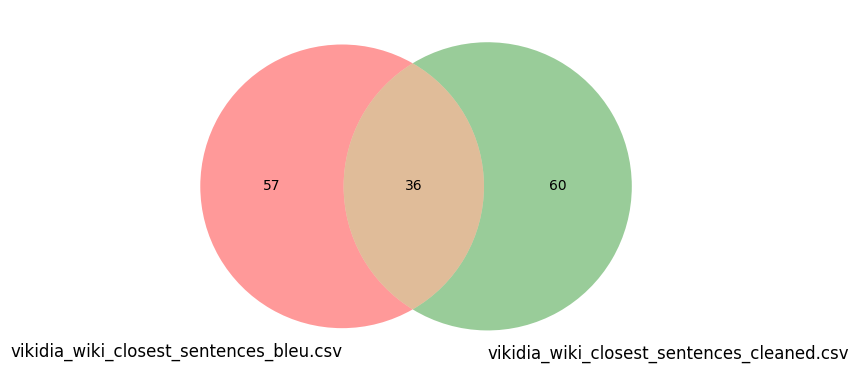

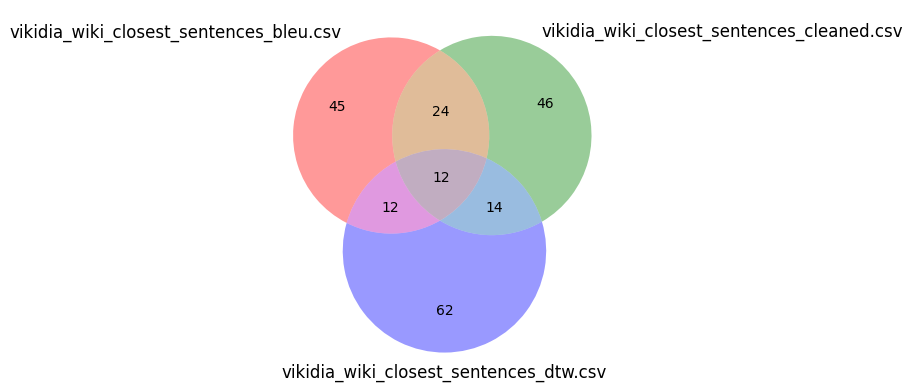

In [ ]:
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt

# Example: Venn diagram for 2 files
venn2([sentence_sets[filenames[0]], sentence_sets[filenames[1]]], set_labels=(filenames[0], filenames[1]))
plt.show()

# Example: Venn diagram for 3 files
venn3([sentence_sets[filenames[0]], sentence_sets[filenames[1]], sentence_sets[filenames[2]]], set_labels=(filenames[0], filenames[1], filenames[2]))
plt.show()


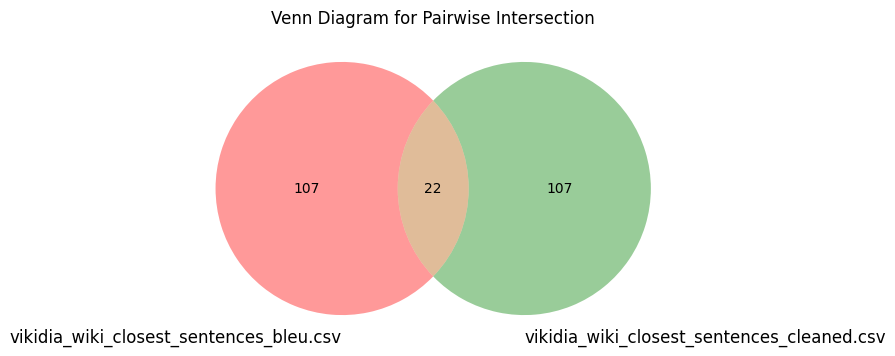

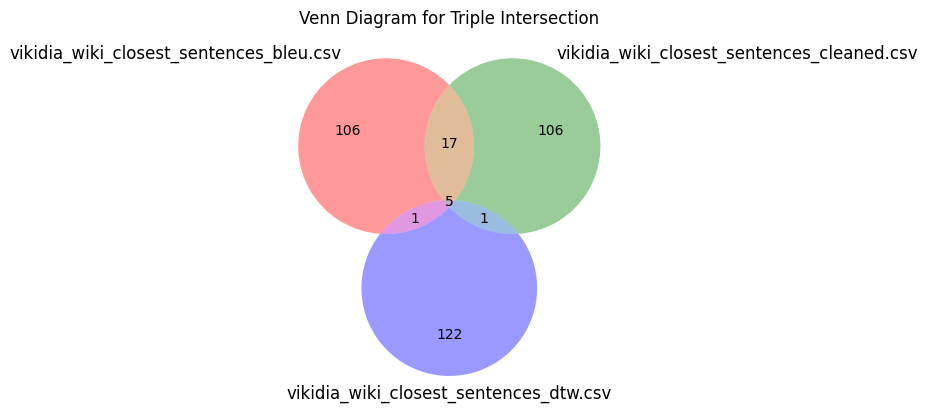

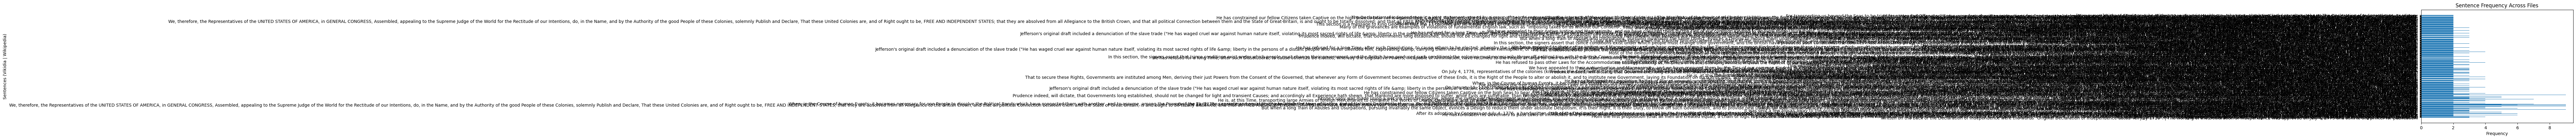

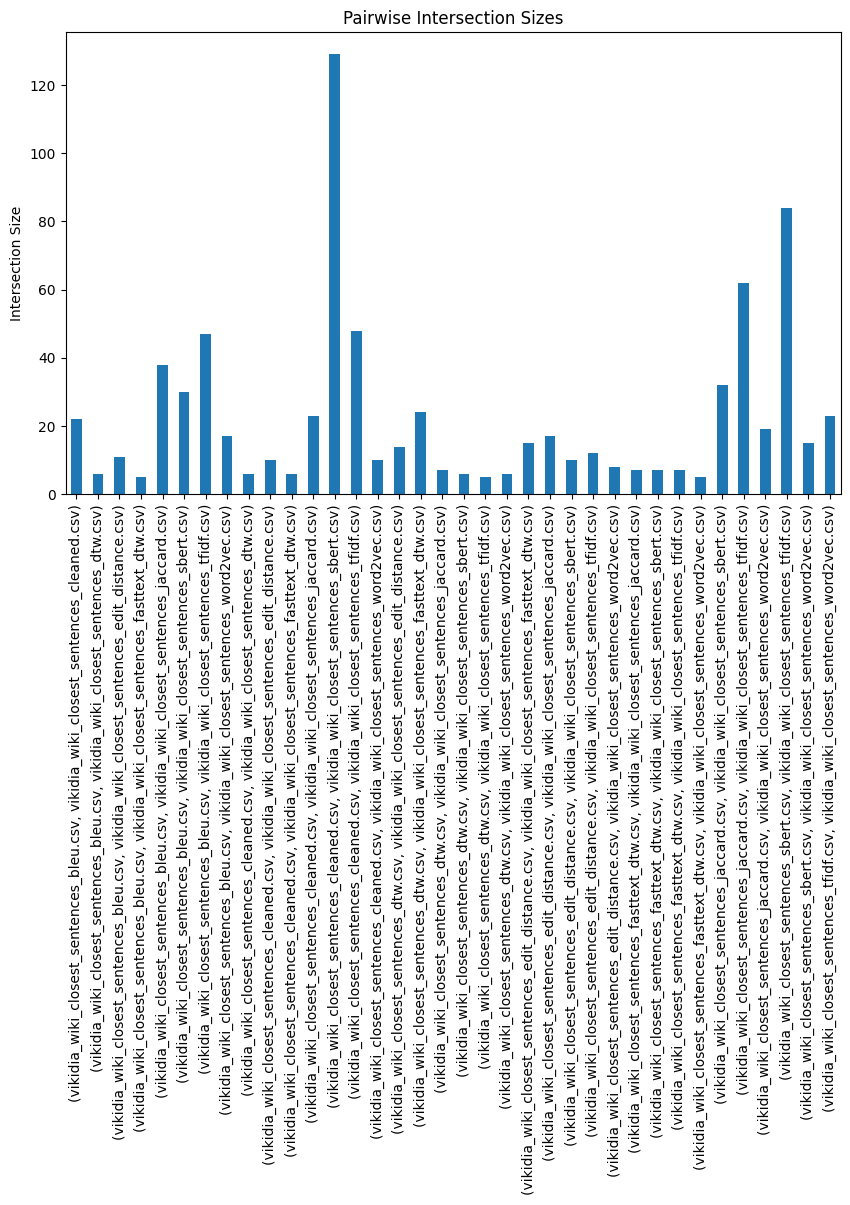

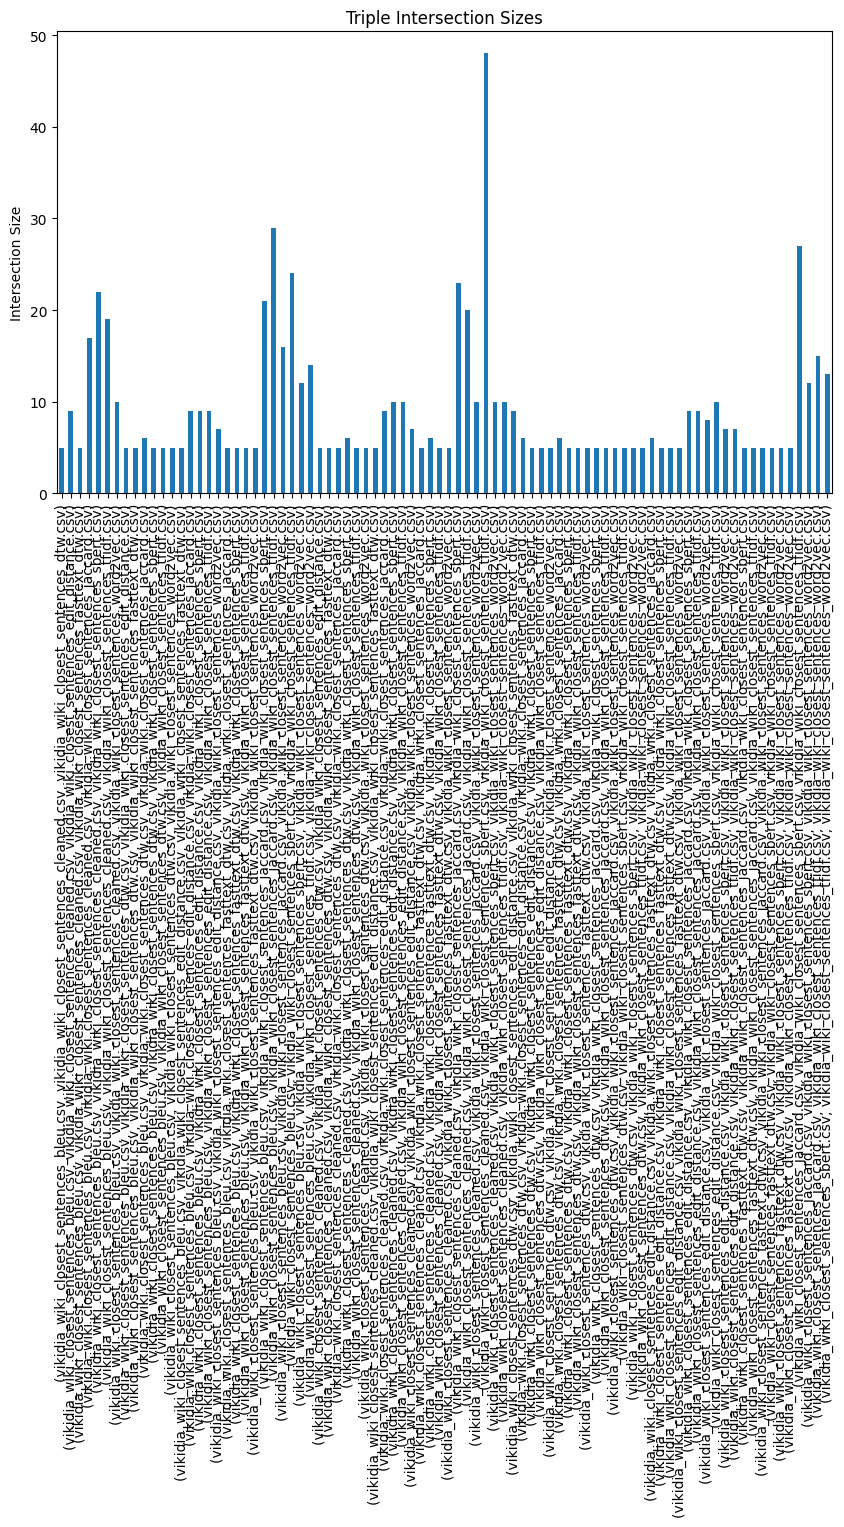

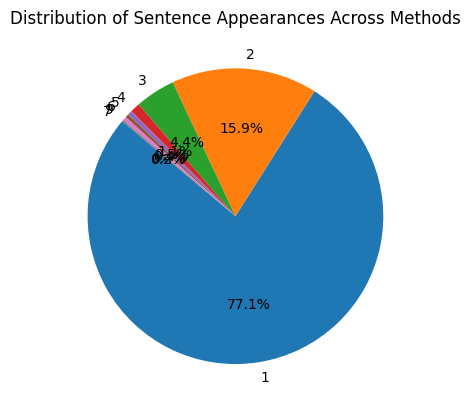

Number of sentences common across all methods: 5


In [ ]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib_venn import venn2, venn3

# 1. Compute Statistics

# Full intersection statistics
full_intersection = compute_intersection(filenames)
full_intersection_count = len(full_intersection)

# Pairwise intersection statistics
pairwise_stats = {}
for combo in combinations(filenames, 2):
    intersection = compute_intersection(combo)
    pairwise_stats[combo] = len(intersection)

# Triple intersection statistics
triple_stats = {}
for combo in combinations(filenames, 3):
    intersection = compute_intersection(combo)
    triple_stats[combo] = len(intersection)

# 2. Plot Venn Diagrams

# Example Venn diagram for a pairwise intersection (adjust filenames accordingly)
venn2([sentence_sets[filenames[0]], sentence_sets[filenames[1]]], set_labels=(filenames[0], filenames[1]))
plt.title("Venn Diagram for Pairwise Intersection")
plt.show()

# Example Venn diagram for a triple intersection (adjust filenames accordingly)
venn3([sentence_sets[filenames[0]], sentence_sets[filenames[1]], sentence_sets[filenames[2]]], set_labels=(filenames[0], filenames[1], filenames[2]))
plt.title("Venn Diagram for Triple Intersection")
plt.show()

# 3. Sentence Frequency Analysis

# Combine all sentences from all sets and count their occurrences
all_sentences = [sentence for sentences in sentence_sets.values() for sentence in sentences]
sentence_frequencies = Counter(all_sentences)

# Convert tuple of sentences (Vikidia, Wikipedia) to strings for visualization
frequent_sentences = [' | '.join(map(str, sentence)) for sentence, freq in sentence_frequencies.items() if freq > 1]
frequencies = [sentence_frequencies[sentence] for sentence in sentence_frequencies if sentence_frequencies[sentence] > 1]


plt.barh(frequent_sentences, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Sentences (Vikidia | Wikipedia)')
plt.title('Sentence Frequency Across Files')
plt.show()


# 4. Distribution of Intersection Sizes

# Bar plot for pairwise intersection sizes
pairwise_df = pd.DataFrame.from_dict(pairwise_stats, orient='index', columns=["Intersection Size"])
pairwise_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Pairwise Intersection Sizes')
plt.ylabel('Intersection Size')
plt.show()

# Bar plot for triple intersection sizes
triple_df = pd.DataFrame.from_dict(triple_stats, orient='index', columns=["Intersection Size"])
triple_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Triple Intersection Sizes')
plt.ylabel('Intersection Size')
plt.show()

# 5. Pie chart of sentence occurrences across number of methods
# Frequency distribution of sentence appearances across methods
freq_counts = pd.Series(list(sentence_frequencies.values())).value_counts()

# Plot Pie chart for frequency counts
plt.pie(freq_counts, labels=freq_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentence Appearances Across Methods')
plt.show()

# 6. Print Summary of Full Intersection
print(f"Number of sentences common across all methods: {full_intersection_count}")


                                    Vikidia Sentence  Vikidia Sentence Length  \
0          United_States_Declaration_of_Independence                        1   
1      The United States Declaration of Independence                        6   
2  The Declaration of Independence is a joint sta...                       22   
3  On July 4, 1776, representatives of the coloni...                       29   
4  Most of the delegates actually signed the docu...                       12   

                               Closest Wiki Sentence  \
0          United States Declaration of Independence   
1          United States Declaration of Independence   
2  By the time that the Declaration of Independen...   
3  The Declaration explained why the Thirteen Col...   
4  On August 2, 1776, a parchment paper copy of t...   

   Wikipedia Sentence Length  
0                          5  
1                          5  
2                         28  
3                         27  
4                    

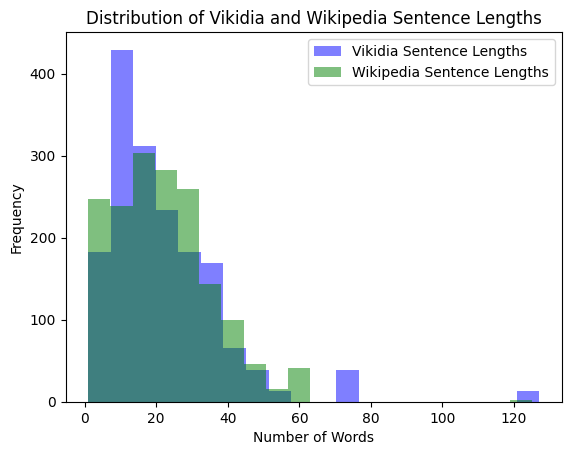

In [ ]:
import os
import pandas as pd
from functools import reduce
from itertools import combinations
import matplotlib.pyplot as plt

# Directory where the CSV files are located
directory = './'
# List of filenames for all sentence comparison methods
filenames = [
    'vikidia_wiki_closest_sentences_bleu.csv',
    'vikidia_wiki_closest_sentences_cleaned.csv',
    'vikidia_wiki_closest_sentences_dtw.csv',
    'vikidia_wiki_closest_sentences_edit_distance.csv',
    'vikidia_wiki_closest_sentences_fasttext_dtw.csv',
    'vikidia_wiki_closest_sentences_jaccard.csv',
    'vikidia_wiki_closest_sentences_sbert.csv',
    'vikidia_wiki_closest_sentences_tfidf.csv',
    'vikidia_wiki_closest_sentences_word2vec.csv'
]

# Load all CSV files into DataFrames
dataframes = {filename: pd.read_csv(os.path.join(directory, filename)) for filename in filenames}

# Function to extract the first non-empty Wikipedia sentence from 'Closest Wiki Sentence 1', 'Closest Wiki Sentence 2', or 'Closest Wiki Sentence 3'
def get_closest_wiki_sentence(df):
    return df.apply(lambda row: row['Closest Wiki Sentence 1'] if pd.notnull(row['Closest Wiki Sentence 1'])
                    else (row['Closest Wiki Sentence 2'] if pd.notnull(row['Closest Wiki Sentence 2'])
                    else row['Closest Wiki Sentence 3']), axis=1)

# Function to compute sentence length (in terms of number of words)
def sentence_length(sentence):
    return len(str(sentence).split())

# Calculate sentence lengths for Vikidia and Wikipedia sentences
sentence_length_data = {}
for filename, df in dataframes.items():
    # Get the closest Wikipedia sentence, with fallback to Sentence 2 or Sentence 3 if necessary
    df['Closest Wiki Sentence'] = get_closest_wiki_sentence(df)

    # Compute lengths of Vikidia and Wikipedia sentences
    df['Vikidia Sentence Length'] = df['Vikidia Sentence'].apply(sentence_length)
    df['Wikipedia Sentence Length'] = df['Closest Wiki Sentence'].apply(sentence_length)

    # Store this info for each file
    sentence_length_data[filename] = df[['Vikidia Sentence', 'Vikidia Sentence Length', 'Closest Wiki Sentence', 'Wikipedia Sentence Length']]

# Example: View one of the files' sentence lengths
print(sentence_length_data['vikidia_wiki_closest_sentences_bleu.csv'].head())

# Visualize the distribution of Vikidia and Wikipedia sentence lengths

# Combine all sentence lengths across all files for comparison
vikidia_lengths = []
wiki_lengths = []

for filename, df in sentence_length_data.items():
    vikidia_lengths.extend(df['Vikidia Sentence Length'])
    wiki_lengths.extend(df['Wikipedia Sentence Length'])

# Plot histograms of sentence lengths
plt.hist(vikidia_lengths, bins=20, alpha=0.5, label='Vikidia Sentence Lengths', color='blue')
plt.hist(wiki_lengths, bins=20, alpha=0.5, label='Wikipedia Sentence Lengths', color='green')
plt.title('Distribution of Vikidia and Wikipedia Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


<ipython-input-47-1e4e85fa8506>:23: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


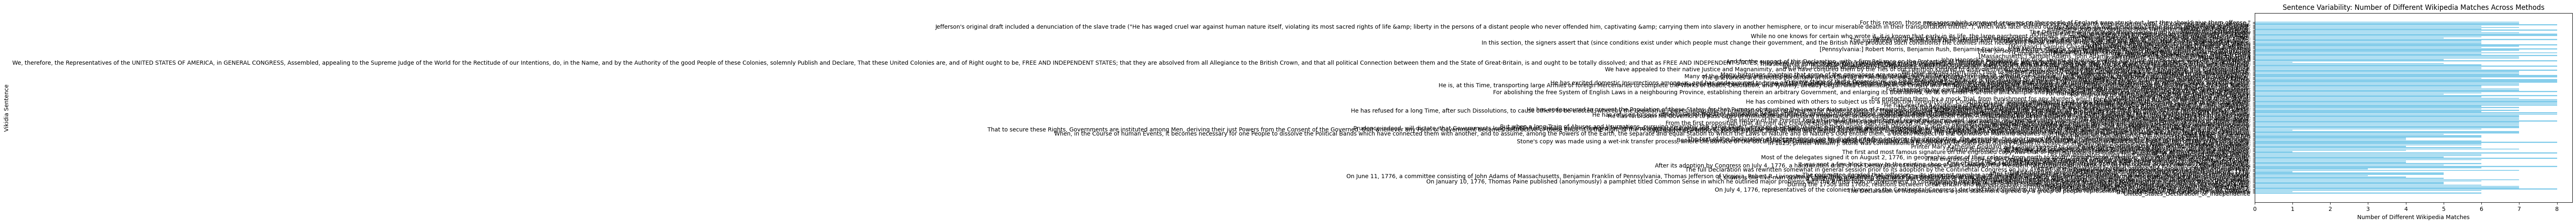

In [ ]:
# Calculate sentence agreement across methods
sentence_agreement = {}

for filename, df in sentence_length_data.items():
    for vikidia_sentence in df['Vikidia Sentence']:
        if vikidia_sentence not in sentence_agreement:
            sentence_agreement[vikidia_sentence] = set()
        sentence_agreement[vikidia_sentence].add(df[df['Vikidia Sentence'] == vikidia_sentence]['Closest Wiki Sentence'].values[0])

# Now analyze the variability of Wikipedia sentences for each Vikidia sentence
variability = {k: len(v) for k, v in sentence_agreement.items()}

# Plot the variability of Wikipedia matches for each Vikidia sentence
vikidia_sentences = list(variability.keys())
variability_counts = list(variability.values())

# Create a bar plot for the sentence variability
plt.figure(figsize=(10, 6))
plt.barh(vikidia_sentences, variability_counts, color='skyblue')
plt.xlabel('Number of Different Wikipedia Matches')
plt.ylabel('Vikidia Sentence')
plt.title('Sentence Variability: Number of Different Wikipedia Matches Across Methods')
plt.tight_layout()

# Display the plot
plt.show()


Compare Sentence Lengths:

In [ ]:
for filename, df in sentence_length_data.items():
    avg_vikidia_len = df['Vikidia Sentence Length'].mean()
    avg_wikipedia_len = df['Wikipedia Sentence Length'].mean()
    print(f"{filename}: Avg Vikidia Length = {avg_vikidia_len}, Avg Wikipedia Length = {avg_wikipedia_len}")


vikidia_wiki_closest_sentences_bleu.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 21.573643410852714
vikidia_wiki_closest_sentences_cleaned.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 21.565891472868216
vikidia_wiki_closest_sentences_dtw.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 16.906976744186046
vikidia_wiki_closest_sentences_edit_distance.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 14.875968992248062
vikidia_wiki_closest_sentences_fasttext_dtw.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 16.8062015503876
vikidia_wiki_closest_sentences_jaccard.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 20.426356589147286
vikidia_wiki_closest_sentences_sbert.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 22.100775193798448
vikidia_wiki_closest_sentences_tfidf.csv: Avg Vikidia Length = 22.286821705426355, Avg Wikipedia Length = 25.02

Outliers:

In [ ]:
# Find large differences between Vikidia and Wikipedia sentence lengths
for filename, df in sentence_length_data.items():
    df['Length Difference'] = abs(df['Vikidia Sentence Length'] - df['Wikipedia Sentence Length'])
    outliers = df[df['Length Difference'] > 10]  # Example: Difference greater than 10 words
    print(f"Outliers in {filename} with large length differences:\n", outliers)


Outliers in vikidia_wiki_closest_sentences_bleu.csv with large length differences:
                                       Vikidia Sentence  \
12   It shows is the five-man drafting committee pr...   
45   When, in the Course of human Events, it become...   
48   That to secure these Rights, Governments are i...   
98   We, therefore, the Representatives of the UNIT...   
125  Jefferson's original draft included a denuncia...   

     Vikidia Sentence Length  \
12                        30   
45                        71   
48                        74   
98                       127   
125                       74   

                                 Closest Wiki Sentence  \
12   It is sometimes described as the signing of th...   
45   The part of the resolution relating to declari...   
48   Anticipating the arrangement of the British Co...   
98   The part of the resolution relating to declari...   
125  Anticipating the arrangement of the British Co...   

     Wikipedia Sentence L

<ipython-input-42-2bb1b6e9145d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length Difference'] = abs(df['Vikidia Sentence Length'] - df['Wikipedia Sentence Length'])
<ipython-input-42-2bb1b6e9145d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Length Difference'] = abs(df['Vikidia Sentence Length'] - df['Wikipedia Sentence Length'])
<ipython-input-42-2bb1b6e9145d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Common Sentence Matches Across Files:

In [ ]:
# Frequency of Vikidia sentences across files
all_vikidia_sentences = pd.concat([df['Vikidia Sentence'] for df in sentence_length_data.values()])
vikidia_sentence_frequencies = all_vikidia_sentences.value_counts()
print("Most common Vikidia sentences across all files:\n", vikidia_sentence_frequencies.head())


Most common Vikidia sentences across all files:
 Vikidia Sentence
United_States_Declaration_of_Independence                                                                                                                                                                                    13
He has made Judges dependent on his Will alone, for the Tenure of their Offices, and Amount and Payment of their Salaries.                                                                                                   13
We must, therefore, acquiesce in the Necessity, which denounces our Separation, and hold them, as we hold the rest of Mankind, Enemies in War, in Peace, Friends.                                                            13
They too have been deaf to the Voice of Justice and of consanguinity.                                                                                                                                                        13
We have appealed to their native Justi

In [ ]:
# Count how often the same Vikidia sentence matches different Wikipedia sentences across methods
sentence_agreement = {}

for filename, df in sentence_length_data.items():
    for vikidia_sentence in df['Vikidia Sentence']:
        if vikidia_sentence not in sentence_agreement:
            sentence_agreement[vikidia_sentence] = set()
        sentence_agreement[vikidia_sentence].add(df[df['Vikidia Sentence'] == vikidia_sentence]['Closest Wiki Sentence'].values[0])

# Now analyze the variability of Wikipedia sentences for each Vikidia sentence
variability = {k: len(v) for k, v in sentence_agreement.items()}
print("Sentence Variability Across Methods:\n", variability)


Sentence Variability Across Methods:
 {'United_States_Declaration_of_Independence': 6, 'The United States Declaration of Independence': 1, 'The Declaration of Independence is a joint statement agreed by a group of people representing the interests of the various thirteen Colonies.': 6, 'On July 4, 1776, representatives of the colonies (known as the Continental Congress) declared the colonies to be free and independent states and explained their justifications for doing so.': 8, 'Most of the delegates actually signed the document later: on August 2.': 7, 'The anniversary of this declaration is now celebrated as Independence Day in the United States.': 7, 'Thomas Jefferson, the man who authored the Declaration of Independence.': 6, 'During the 1750s and 1760s, relations between Great Britain and thirteen British colonies along the eastern shore of North America became increasingly strained.': 5, 'Fighting broke out in 1775 at Lexington and Concord, marking the beginning of the American R

Identifying Alignment Disagreements:

In [ ]:
alignment_disagreements = {}

for vikidia_sentence, wikipedia_matches in sentence_agreement.items():
    if len(wikipedia_matches) > 1:
        alignment_disagreements[vikidia_sentence] = wikipedia_matches

print("Alignment Disagreements (Vikidia sentences with varying Wikipedia matches):")
for vikidia_sentence, wikipedia_matches in alignment_disagreements.items():
    print(f"Vikidia: {vikidia_sentence} -> Wikipedia Matches: {wikipedia_matches}")


Alignment Disagreements (Vikidia sentences with varying Wikipedia matches):
Vikidia: United_States_Declaration_of_Independence -> Wikipedia Matches: {'Dumbauld, Edward.', 'p>', '<', 'Signing', 'Cleveland: Press of Case Western Reserve University, 1969. .', 'United States Declaration of Independence'}
Vikidia: The Declaration of Independence is a joint statement agreed by a group of people representing the interests of the various thirteen Colonies. -> Wikipedia Matches: {'The Declaration of Independence is a plot device in the 2004 American film National Treasure.', 'The Manifesto of the Province of Flanders (1790) was the first foreign derivation of the Declaration; others include the Venezuelan Declaration of Independence (1811), the Liberian Declaration of Independence (1847), the declarations of secession by the Confederate States of America (1860–61), and the Vietnamese Proclamation of Independence (1945).', 'The Declaration explained why the Thirteen Colonies at war with the King

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def compute_ngrams(sentences, n=2):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngram_matrix = vectorizer.fit_transform(sentences)
    ngrams = vectorizer.get_feature_names_out()
    counts = ngram_matrix.sum(axis=0).A1
    return dict(zip(ngrams, counts))

# Compute bi-grams (2-grams) in Vikidia sentences
vikidia_bigrams = compute_ngrams(df['Vikidia Sentence'], n=2)
print("Most Common Vikidia Bigrams:\n", sorted(vikidia_bigrams.items(), key=lambda item: item[1], reverse=True)[:10])


Most Common Vikidia Bigrams:
 [('of the', 49), ('he has', 20), ('to the', 13), ('in the', 12), ('the british', 12), ('the declaration', 12), ('declaration of', 11), ('of independence', 10), ('on the', 10), ('on july', 8)]


In [ ]:
!pip install awesome-align --upgrade


In [ ]:
!git clone https://github.com/neulab/awesome-align.git

Cloning into 'awesome-align'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 343 (delta 100), reused 86 (delta 86), pack-reused 228 (from 1)
Receiving objects: 100% (343/343), 596.38 KiB | 7.02 MiB/s, done.
Resolving deltas: 100% (207/207), done.


In [ ]:
!pip install -r awesome-align/requirements.txt


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer
from awesome_align import AwesomeAlignModel

# Path to your specific file (use the actual path to your file)
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Extract Vikidia and Wikipedia sentences from the CSV
vikidia_sentences = df['Vikidia Sentence'].tolist()
wikipedia_sentences = df['Wikipedia Sentence'].tolist()

# Initialize the tokenizer and Awesome-align model (replace this with your model if needed)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AwesomeAlignModel.from_pretrained('bert-base-multilingual-cased', model_name_or_path='bert-base-multilingual-cased')

# Function to align words between Vikidia and Wikipedia sentences
def align_sentences(vikidia_sentences, wikipedia_sentences, model, tokenizer):
    alignments = []
    for vikidia_sentence, wikipedia_sentence in zip(vikidia_sentences, wikipedia_sentences):
        inputs = tokenizer([vikidia_sentence], [wikipedia_sentence], return_tensors='pt', padding=True)

        with torch.no_grad():
            align_prob = model(**inputs).align

        sentence_alignment = []
        for i, j in align_prob:
            vikidia_word = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][i].item())
            wikipedia_word = tokenizer.convert_ids_to_tokens(inputs['input_ids'][1][j].item())
            sentence_alignment.append((vikidia_word, wikipedia_word))
        alignments.append(sentence_alignment)
    return alignments

# Align all Vikidia and Wikipedia sentence pairs from the CSV
alignments = align_sentences(vikidia_sentences, wikipedia_sentences, model, tokenizer)

# Print the alignments
for idx, sentence_alignment in enumerate(alignments):
    print(f"Alignment for sentence pair {idx + 1}:")
    for vikidia_word, wikipedia_word in sentence_alignment:
        print(f"Vikidia word: {vikidia_word} -> Wikipedia word: {wikipedia_word}")


ImportError: cannot import name 'AwesomeAlignModel' from 'awesome_align' (/usr/local/lib/python3.10/dist-packages/awesome_align/__init__.py)

In [ ]:
import pandas as pd

# Load your CSV file
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'
df = pd.read_csv(file_path)

# Extract the relevant columns (assuming they are named 'Vikidia Sentence' and 'Wikipedia Sentence')
vikidia_sentences = df['Vikidia Sentence']
wikipedia_sentences = df['Wikipedia Sentence']

# Combine them into a tab-separated format
with open('input_sentences.txt', 'w') as f:
    for vikidia_sentence, wikipedia_sentence in zip(vikidia_sentences, wikipedia_sentences):
        f.write(f"{vikidia_sentence}\t{wikipedia_sentence}\n")

print("Input file saved as 'input_sentences.txt'")


Input file saved as 'input_sentences.txt'


In [ ]:
!awesome-align \
  --output_file=aligned_output.txt \
  --model_name_or_path=bert-base-multilingual-cased \
  --data_file=input_sentences.txt \
  --extraction 'softmax' \
  --batch_size 32


2024-09-30 18:38:11.440905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 18:38:11.487788: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 18:38:11.503439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 18:38:14.314769: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Downloading: 100% 625/625 [00:00<00:00, 1.43MB/s]
Downloading: 100% 996k/996k [00:00<00:00, 9.28MB/s]
Downloading: 100% 714M/714M [00:22<00:00, 32.2MB/s]
/usr/local/lib/python3.10/dist-packages/awesome_align/modeling_utils.py:467: FutureWarn

In [ ]:
# Read the alignment output
with open('aligned_output.txt', 'r') as f:
    alignments = f.readlines()

# Print the alignments
for line in alignments:
    print(line.strip())


In [ ]:
import pandas as pd
import re

# Load your CSV file
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'
df = pd.read_csv(file_path)

# Function to clean sentences by removing problematic characters
def clean_sentence(sentence):
    # Remove special characters, excessive whitespaces, or HTML entities
    sentence = re.sub(r'[\n\r\t]+', ' ', sentence)  # Remove newlines and tabs
    sentence = re.sub(r'["\'\\]', '', sentence)     # Remove quotation marks
    sentence = re.sub(r'\s+', ' ', sentence)        # Normalize excessive spaces
    sentence = sentence.strip()                     # Trim leading/trailing whitespace
    return sentence

# Apply the cleaning function to Vikidia and Wikipedia sentences
df['Vikidia Sentence'] = df['Vikidia Sentence'].apply(clean_sentence)
df['Wikipedia Sentence'] = df['Wikipedia Sentence'].apply(clean_sentence)

# Save the cleaned file as a tab-separated text file
with open('cleaned_input_sentences.txt', 'w') as f:
    for vikidia_sentence, wikipedia_sentence in zip(df['Vikidia Sentence'], df['Wikipedia Sentence']):
        f.write(f"{vikidia_sentence}\t{wikipedia_sentence}\n")

print("Cleaned input file saved as 'cleaned_input_sentences.txt'")


Cleaned input file saved as 'cleaned_input_sentences.txt'


In [ ]:
!awesome-align \
  --output_file=aligned_output.txt \
  --model_name_or_path=bert-base-multilingual-cased \
  --data_file=cleaned_input_sentences.txt \
  --extraction 'softmax' \
  --batch_size 32


2024-09-30 19:46:41.705834: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 19:46:41.764885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 19:46:41.782752: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 19:46:45.053930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/awesome_align/modeling_utils.py:467: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to 

In [ ]:
# Read the alignment output
with open('aligned_output.txt', 'r') as f:
    alignments = f.readlines()

# Print the alignments
for line in alignments:
    print(line.strip())


use fast-align

In [ ]:
!git clone https://github.com/clab/fast_align.git
!cd fast_align
!mkdir -p fast_align/build
!cd fast_align/build && cmake .. && make




fatal: destination path 'fast_align' already exists and is not an empty directory.
CMake Warning (dev) at CMakeLists.txt:1 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
CMake Deprecation Warning at CMakeLists.txt:2 (cmake_minimum_required):
  Compatibility with CMake < 3.5 will be remove

In [ ]:
!./fast_align/build/fast_align -i input_sentences.txt -d -o -v > align_output.txt


ARG=i
ARG=d
ARG=o
ARG=v
INITIAL PASS 
expected target length = source length * 1.54917
ITERATION 1
  log_e likelihood: -44016.2
  log_2 likelihood: -63502
     cross entropy: 29.8974
        perplexity: 1e+09
      posterior p0: 0.08
 posterior al-feat: -0.16832
       size counts: 80
ITERATION 2
  log_e likelihood: -15806.4
  log_2 likelihood: -22803.8
     cross entropy: 10.7363
        perplexity: 1705.83
      posterior p0: 0.172644
 posterior al-feat: -0.11166
       size counts: 80
  1  model al-feat: -0.167744 (tension=4)
  2  model al-feat: -0.146901 (tension=5.12168)
  3  model al-feat: -0.136333 (tension=5.82651)
  4  model al-feat: -0.129977 (tension=6.31998)
  5  model al-feat: -0.125773 (tension=6.68633)
  6  model al-feat: -0.122816 (tension=6.96859)
  7  model al-feat: -0.120645 (tension=7.1917)
  8  model al-feat: -0.119002 (tension=7.37141)
     final tension: 7.51824
ITERATION 3
  log_e likelihood: -10378.1
  log_2 likelihood: -14972.4
     cross entropy: 7.04914
    

In [ ]:
import re

# Path to input sentence pairs and alignments
sentence_pairs_file = 'input_sentences.txt'
alignments_file = 'align_output.txt'

# Load the sentence pairs
with open(sentence_pairs_file, 'r') as f:
    sentence_pairs = f.readlines()

# Load the alignments
with open(alignments_file, 'r') as f:
    alignments = f.readlines()

# Function to reverse the alignment indices to actual words
def reverse_alignment(vikidia_sentence, wikipedia_sentence, alignment):
    vikidia_words = vikidia_sentence.strip().split()
    wikipedia_words = wikipedia_sentence.strip().split()

    # Alignment format is like "0-0 1-2 3-1"
    word_alignment = []
    for pair in alignment.strip().split():
        i, j = map(int, pair.split('-'))  # Split and convert to integers
        if i < len(vikidia_words) and j < len(wikipedia_words):
            vikidia_word = vikidia_words[i]
            wikipedia_word = wikipedia_words[j]
            word_alignment.append((vikidia_word, wikipedia_word))

    return word_alignment

# Process each sentence pair and alignment
for i, sentence_pair in enumerate(sentence_pairs):
    vikidia_sentence, wikipedia_sentence = sentence_pair.strip().split('\t')
    alignment = alignments[i]

    aligned_words = reverse_alignment(vikidia_sentence, wikipedia_sentence, alignment)

    # Print or save the aligned word pairs
    print(f"Alignment for Sentence Pair {i + 1}:")
    for vikidia_word, wikipedia_word in aligned_words:
        print(f"Vikidia word: {vikidia_word} -> Wikipedia word: {wikipedia_word}")
    print("\n")


Alignment for Sentence Pair 1:
Vikidia word: A -> Wikipedia word: The
Vikidia word: A -> Wikipedia word: signatures
Vikidia word: A -> Wikipedia word: fifty-six
Vikidia word: total -> Wikipedia word: delegates
Vikidia word: total -> Wikipedia word: are
Vikidia word: total -> Wikipedia word: affixed;
Vikidia word: total -> Wikipedia word: however,
Vikidia word: of -> Wikipedia word: the
Vikidia word: of -> Wikipedia word: exact
Vikidia word: 56 -> Wikipedia word: date
Vikidia word: 56 -> Wikipedia word: when
Vikidia word: 56 -> Wikipedia word: each
Vikidia word: 56 -> Wikipedia word: person
Vikidia word: delegates -> Wikipedia word: signed
Vikidia word: delegates -> Wikipedia word: it
Vikidia word: delegates -> Wikipedia word: has
Vikidia word: delegates -> Wikipedia word: long
Vikidia word: eventually -> Wikipedia word: been
Vikidia word: eventually -> Wikipedia word: the
Vikidia word: eventually -> Wikipedia word: subject
Vikidia word: signed. -> Wikipedia word: of
Vikidia word: signe

NLTK alignbment

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from collections import defaultdict

# Download necessary NLTK data (if not already installed)
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words to be removed during tokenization
stop_words = set(stopwords.words('english'))

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    words = word_tokenize(sentence.lower())  # Tokenize and lowercasing
    words = [w for w in words if w.isalpha() and w not in stop_words]  # Remove non-alphabetic tokens and stopwords
    return words

# Function to align words based on exact token matching
def align_words(vikidia_sentences, wikipedia_sentences):
    alignments = defaultdict(list)

    for vikidia_sentence, wikipedia_sentence in zip(vikidia_sentences, wikipedia_sentences):
        vikidia_tokens = clean_and_tokenize(vikidia_sentence)
        wikipedia_tokens = clean_and_tokenize(wikipedia_sentence)

        # Align words based on exact matches
        for vikidia_word in vikidia_tokens:
            if vikidia_word in wikipedia_tokens:
                alignments[vikidia_sentence].append((vikidia_word, vikidia_word))  # Exact match
            else:
                alignments[vikidia_sentence].append((vikidia_word, "NO_MATCH"))

    return alignments

# Load the pairwise CSV file
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'
df = pd.read_csv(file_path)

# Assuming the CSV file has columns 'Vikidia Sentence' and 'Wikipedia Sentence'
vikidia_sentences = df['Vikidia Sentence'].tolist()
wikipedia_sentences = df['Wikipedia Sentence'].tolist()

# Perform the word alignment
alignments = align_words(vikidia_sentences, wikipedia_sentences)

# Print the results
for vikidia_sentence, aligned_words in alignments.items():
    print(f"Vikidia sentence: {vikidia_sentence}")
    for vikidia_word, wikipedia_word in aligned_words:
        print(f"  Vikidia word: {vikidia_word} -> Wikipedia word: {wikipedia_word}")

# Optionally, save the alignments to a CSV file
alignment_data = []

for vikidia_sentence, aligned_words in alignments.items():
    for vikidia_word, wikipedia_word in aligned_words:
        alignment_data.append([vikidia_sentence, vikidia_word, wikipedia_word])

alignment_df = pd.DataFrame(alignment_data, columns=["Vikidia Sentence", "Vikidia Word", "Wikipedia Word"])
alignment_df.to_csv("word_alignment_output.csv", index=False)
print("Word alignments saved to 'word_alignment_output.csv'")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Vikidia sentence: A total of 56 delegates eventually signed.
  Vikidia word: total -> Wikipedia word: NO_MATCH
  Vikidia word: delegates -> Wikipedia word: delegates
  Vikidia word: eventually -> Wikipedia word: NO_MATCH
  Vikidia word: signed -> Wikipedia word: signed
  Vikidia word: total -> Wikipedia word: NO_MATCH
  Vikidia word: delegates -> Wikipedia word: delegates
  Vikidia word: eventually -> Wikipedia word: NO_MATCH
  Vikidia word: signed -> Wikipedia word: signed
Vikidia sentence: During the 1750s and 1760s, relations between Great Britain and thirteen British colonies along the eastern shore of North America became increasingly strained.
  Vikidia word: relations -> Wikipedia word: NO_MATCH
  Vikidia word: great -> Wikipedia word: great
  Vikidia word: britain -> Wikipedia word: britain
  Vikidia word: thirteen -> Wikipedia word: thirteen
  Vikidia word: british -> Wikipedia word: british
  Vikidia word: colonies -> Wikipedia word: colonies
  Vikidia word: along -> Wikipedi

In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Function to get word embeddings for a sentence
def get_word_embeddings(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.squeeze(0), inputs  # Return embeddings and input tokens

# Function to align words using cosine similarity
def align_words(vikidia_sentence, wikipedia_sentence, tokenizer, model):
    # Get embeddings and tokens for both sentences
    vikidia_embeddings, vikidia_inputs = get_word_embeddings(vikidia_sentence, tokenizer, model)
    wikipedia_embeddings, wikipedia_inputs = get_word_embeddings(wikipedia_sentence, tokenizer, model)

    # Compute cosine similarity between Vikidia and Wikipedia word embeddings
    similarity_matrix = cosine_similarity(vikidia_embeddings, wikipedia_embeddings)

    # Find the best alignment based on the highest similarity
    alignment = []
    for i in range(len(vikidia_embeddings)):
        j = np.argmax(similarity_matrix[i])  # Find the best matching word in Wikipedia

        # Get the token ids and convert them to words
        vikidia_word = tokenizer.convert_ids_to_tokens(vikidia_inputs['input_ids'][0][i].item())
        wikipedia_word = tokenizer.convert_ids_to_tokens(wikipedia_inputs['input_ids'][0][j].item())

        alignment.append((vikidia_word, wikipedia_word))

    return alignment

# Load your pairwise CSV file
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'
df = pd.read_csv(file_path)

# Assuming the CSV file has columns 'Vikidia Sentence' and 'Wikipedia Sentence'
vikidia_sentences = df['Vikidia Sentence'].tolist()
wikipedia_sentences = df['Wikipedia Sentence'].tolist()

# Perform the word alignment for each sentence pair and save results
alignments = []
for vikidia_sentence, wikipedia_sentence in zip(vikidia_sentences, wikipedia_sentences):
    alignment = align_words(vikidia_sentence, wikipedia_sentence, tokenizer, model)
    alignments.append(alignment)

# Print a few example alignments
for i, alignment in enumerate(alignments[:5]):  # Show first 5 alignments
    print(f"Alignment for sentence pair {i + 1}:")
    for vikidia_word, wikipedia_word in alignment:
        print(f"Vikidia word: {vikidia_word} -> Wikipedia word: {wikipedia_word}")
    print("\n")

# Optionally save the alignments to a CSV file
alignment_data = []

for i, alignment in enumerate(alignments):
    vikidia_sentence = vikidia_sentences[i]
    for vikidia_word, wikipedia_word in alignment:
        alignment_data.append([vikidia_sentence, vikidia_word, wikipedia_word])

alignment_df = pd.DataFrame(alignment_data, columns=["Vikidia Sentence", "Vikidia Word", "Wikipedia Word"])
alignment_df.to_csv("bert_word_alignment_output.csv", index=False)
print("Word alignments saved to 'bert_word_alignment_output.csv'")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Alignment for sentence pair 1:
Vikidia word: [CLS] -> Wikipedia word: [CLS]
Vikidia word: a -> Wikipedia word: [CLS]
Vikidia word: total -> Wikipedia word: the
Vikidia word: of -> Wikipedia word: of
Vikidia word: 56 -> Wikipedia word: six
Vikidia word: delegates -> Wikipedia word: delegates
Vikidia word: eventually -> Wikipedia word: signed
Vikidia word: signed -> Wikipedia word: signed
Vikidia word: . -> Wikipedia word: .
Vikidia word: [SEP] -> Wikipedia word: [SEP]


Alignment for sentence pair 2:
Vikidia word: [CLS] -> Wikipedia word: [CLS]
Vikidia word: during -> Wikipedia word: the
Vikidia word: the -> Wikipedia word: the
Vikidia word: 1750 -> Wikipedia word: britain
Vikidia word: ##s -> Wikipedia word: of
Vikidia word: and -> Wikipedia word: with
Vikidia word: 1760 -> Wikipedia word: britain
Vikidia word: ##s -> Wikipedia word: of
Vikidia word: , -> Wikipedia word: .
Vikidia word: relations -> Wikipedia word: at
Vikidia word: between -> Wikipedia word: with
Vikidia word: great ->

In [ ]:
!pip install fasttext


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296189 sha256=110a172c0f6bb93f29a272a9eaebb4f07a6df9608f1ce9d3330bb3210b111e04
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [ ]:
import fasttext
import fasttext.util
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Download pretrained FastText embeddings (you can change the language as needed)
# fasttext.util.download_model('en', if_exists='ignore')  # Download FastText model for English
fasttext.util.download_model('en', if_exists='ignore')  # Download FastText model for English
ft = fasttext.load_model('cc.en.300.bin')

# Function to get word embeddings using FastText
def get_fasttext_embedding(word, model):
    return model.get_word_vector(word)

# Function to align words using FastText embeddings and cosine similarity
def align_words(vikidia_sentence, wikipedia_sentence, ft_model):
    vikidia_words = vikidia_sentence.split()
    wikipedia_words = wikipedia_sentence.split()

    vikidia_embeddings = np.array([get_fasttext_embedding(word, ft_model) for word in vikidia_words])
    wikipedia_embeddings = np.array([get_fasttext_embedding(word, ft_model) for word in wikipedia_words])

    # Compute cosine similarity between Vikidia and Wikipedia word embeddings
    similarity_matrix = cosine_similarity(vikidia_embeddings, wikipedia_embeddings)

    # Find the best alignment based on the highest similarity
    alignment = []
    for i in range(len(vikidia_words)):
        j = np.argmax(similarity_matrix[i])  # Find the best matching word in Wikipedia
        alignment.append((vikidia_words[i], wikipedia_words[j]))

    return alignment

# Load your pairwise CSV file
file_path = './pairwise_intersection_vikidia_wiki_closest_sentences_sbert_vikidia_wiki_closest_sentences_tfidf.csv'
df = pd.read_csv(file_path)

# Assuming the CSV file has columns 'Vikidia Sentence' and 'Wikipedia Sentence'
vikidia_sentences = df['Vikidia Sentence'].tolist()
wikipedia_sentences = df['Wikipedia Sentence'].tolist()

# Perform the word alignment for each sentence pair and save results
alignments = []
for vikidia_sentence, wikipedia_sentence in zip(vikidia_sentences, wikipedia_sentences):
    alignment = align_words(vikidia_sentence, wikipedia_sentence, ft)
    alignments.append(alignment)

# Print a few example alignments
for i, alignment in enumerate(alignments[:5]):  # Show first 5 alignments
    print(f"Alignment for sentence pair {i + 1}:")
    for vikidia_word, wikipedia_word in alignment:
        print(f"Vikidia word: {vikidia_word} -> Wikipedia word: {wikipedia_word}")
    print("\n")

# Optionally save the alignments to a CSV file
alignment_data = []

for i, alignment in enumerate(alignments):
    vikidia_sentence = vikidia_sentences[i]
    for vikidia_word, wikipedia_word in alignment:
        alignment_data.append([vikidia_sentence, vikidia_word, wikipedia_word])

alignment_df = pd.DataFrame(alignment_data, columns=["Vikidia Sentence", "Vikidia Word", "Wikipedia Word"])
alignment_df.to_csv("fasttext_word_alignment_output.csv", index=False)
print("Word alignments saved to 'fasttext_word_alignment_output.csv'")



Alignment for sentence pair 1:
Vikidia word: A -> Wikipedia word: The
Vikidia word: total -> Wikipedia word: fifty-six
Vikidia word: of -> Wikipedia word: of
Vikidia word: 56 -> Wikipedia word: fifty-six
Vikidia word: delegates -> Wikipedia word: delegates
Vikidia word: eventually -> Wikipedia word: when
Vikidia word: signed. -> Wikipedia word: signed


Alignment for sentence pair 2:
Vikidia word: During -> Wikipedia word: The
Vikidia word: the -> Wikipedia word: the
Vikidia word: 1750s -> Wikipedia word: Britain
Vikidia word: and -> Wikipedia word: with
Vikidia word: 1760s, -> Wikipedia word: states,
Vikidia word: relations -> Wikipedia word: war
Vikidia word: between -> Wikipedia word: with
Vikidia word: Great -> Wikipedia word: Great
Vikidia word: Britain -> Wikipedia word: Britain
Vikidia word: and -> Wikipedia word: with
Vikidia word: thirteen -> Wikipedia word: thirteen
Vikidia word: British -> Wikipedia word: British
Vikidia word: colonies -> Wikipedia word: Colonies
Vikidia wo

hunaligner
Overview of Hunalign

Hunalign is an automatic sentence alignment tool that aligns sentences between two parallel texts, typically in different languages. It uses a combination of dictionaries and heuristic methods based on sentence lengths to achieve accurate alignments. While it's optimized for bilingual corpora, it can also be adapted for monolingual alignment with some considerations.

Key Features:
Dictionary-Based Alignment: Uses bilingual dictionaries to improve alignment accuracy.
Heuristic Methods: Employs sentence length and other heuristics to align sentences effectively.
Flexible Output Formats: Supports output in formats like TMX (Translation Memory eXchange).
Open Source: Available on GitHub, allowing for customization and integration.

In [ ]:
# Remove the existing hunalign directory
!rm -rf /content/hunalign


In [ ]:
# Clone Hunalign repository
!git clone https://github.com/danielvarga/hunalign.git


Cloning into 'hunalign'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 397 (delta 79), reused 77 (delta 77), pack-reused 313 (from 1)
Receiving objects: 100% (397/397), 7.60 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (192/192), done.


In [ ]:

%cd /content/hunalign/src/hunalign
# Compile Hunalign
!make

/content/hunalign/src/hunalign
g++  -O9 -ffast-math -funroll-loops -I ../include  -c -o alignerTool.o alignerTool.cpp
g++  -O9 -ffast-math -funroll-loops -I ../include  -c -o alignment.o alignment.cpp
g++  -O9 -ffast-math -funroll-loops -I ../include  -c -o bloom.o bloom.cpp
g++  -O9 -ffast-math -funroll-loops -I ../include  -c -o bookToMatrix.o bookToMatrix.cpp
g++  -O9 -ffast-math -funroll-loops -I ../include  -c -o cooccurrence.o cooccurrence.cpp
In file included from /usr/include/c++/11/ext/hash_map:60,
                 from ../include/portableHash.h:23,
                 from cooccurrence.cpp:36:
/usr/include/c++/11/backward/backward_warning.h:32:2: warning: #warning This file includes at least one deprecated or antiquated header which may be removed without further notice at a future date. Please use a non-deprecated interface with equivalent functionality instead. For a listing of replacement headers and interfaces, consult the file backward_warning.h. To disable this warning use

In [ ]:
# Verify that Hunalign has been installed correctly
!./hunalign/hunalign -h

/bin/bash: line 1: ./hunalign/hunalign: Not a directory


KeyBERT: A method using BERT embeddings to find keywords.

Vikidia as Source: Since Vikidia contains simpler sentences, it can be considered as the source.
Wikipedia as Target: Wikipedia, being more complex, should be treated as the target.

In [ ]:
!pip install keybert


In [ ]:
import spacy
from keybert import KeyBERT
import re

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Function to clean individual sentences by removing HTML-like tags and unwanted symbols
def clean_sentence(sentence):
    sentence = re.sub(r'<[^>]+>', '', sentence)  # Remove everything within <>
    sentence = re.sub(r'\s+', ' ', sentence)  # Remove extra whitespace
    return sentence.strip()

# Function to split text into sentences using SpaCy
def split_into_sentences(text):
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    return sentences

# Read, split, and clean the sentences while filtering out invalid ones
def read_clean_split_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    # Split into sentences
    sentences = split_into_sentences(text)
    # Clean each sentence and filter out sentences that are empty or just tags
    cleaned_sentences = [clean_sentence(sentence) for sentence in sentences if clean_sentence(sentence)]
    return cleaned_sentences

# Paths to your files
vikidia_file_path = '/content/vikidia-en-political.ol'
wiki_file_path = '/content/wiki-en-political.ol'

# Split and clean the sentences
vikidia_sentences = read_clean_split_file(vikidia_file_path)
wiki_sentences = read_clean_split_file(wiki_file_path)

# Initialize KeyBERT model
model = KeyBERT()

# Function to extract keywords from sentences using KeyBERT
def extract_keywords(sentences, top_n=5):
    keyword_list = []
    for sentence in sentences:
        keywords = model.extract_keywords(sentence, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
        keyword_list.append(keywords)
    return keyword_list

# Extract keywords for Vikidia and Wikipedia sentences
vikidia_keywords = extract_keywords(vikidia_sentences)
wiki_keywords = extract_keywords(wiki_sentences)

# Print the extracted keywords for both sets (You can save or align them afterward)
print("Vikidia Keywords:")
for i, sentence_keywords in enumerate(vikidia_keywords[:5]):  # Limiting to 5 sentences for demo
    print(f"Sentence {i+1}: {vikidia_sentences[i]}")
    print(f"Keywords: {sentence_keywords}\n")

print("Wikipedia Keywords:")
for i, sentence_keywords in enumerate(wiki_keywords[:5]):  # Limiting to 5 sentences for demo
    print(f"Sentence {i+1}: {wiki_sentences[i]}")
    print(f"Keywords: {sentence_keywords}\n")

# Example: Align the first sentence's keywords between Vikidia and Wikipedia
print(f"Vikidia Keywords for Sentence 1: {vikidia_keywords[0]}")
print(f"Wikipedia Keywords for Sentence 1: {wiki_keywords[0]}")


Vikidia Keywords:
Sentence 1: United_States_Declaration_of_Independence
Keywords: [('united_states_declaration_of_independence', 1.0)]

Sentence 2: The United States Declaration of Independence
Keywords: [('declaration independence', 0.8684), ('independence', 0.7141), ('states declaration', 0.6803), ('declaration', 0.6253), ('united states', 0.3285)]

Sentence 3: The Declaration of Independence is a joint statement agreed by a group of people representing the interests of the various thirteen Colonies.
Keywords: [('declaration independence', 0.6885), ('independence', 0.5668), ('thirteen colonies', 0.5564), ('declaration', 0.5055), ('independence joint', 0.5017)]

Sentence 4: On July 4, 1776, representatives of the colonies (known as the Continental Congress) declared the colonies to be free and independent states and explained their justifications for doing so.
Keywords: [('1776 representatives', 0.6633), ('july 1776', 0.6336), ('1776', 0.623), ('declared colonies', 0.6172), ('represen

In [ ]:
# Write the keywords to a dictionary file for Hunalign (matching keywords 1-to-1)
with open("hunalign_dictionary.txt", "w", encoding="utf-8") as file:
    for vikidia_kw, wiki_kw in zip(vikidia_keywords, wiki_keywords):
        # Take the top keyword from each sentence pair and add it to the dictionary
        if vikidia_kw and wiki_kw:
            file.write(f"{vikidia_kw[0][0]}\t{wiki_kw[0][0]}\t1\n")  # Source keyword, target keyword, weight

print("Dictionary saved to 'hunalign_dictionary.txt'")

Dictionary saved to 'hunalign_dictionary.txt'


In [ ]:
# Save the segmented sentences to text files
with open('vikidia_sentences.txt', 'w') as file:
    file.write("\n".join(vikidia_sentences))

with open('wiki_sentences.txt', 'w') as file:
    file.write("\n".join(wiki_sentences))

# Verify that the files have been saved
!ls -l vikidia_sentences.txt wiki_sentences.txt


-rw-r--r-- 1 root root 17866 Oct 23 20:38 vikidia_sentences.txt
-rw-r--r-- 1 root root 59947 Oct 23 20:38 wiki_sentences.txt


In [ ]:
!./hunalign -text hunalign_dictionary.txt vikidia_sentences.txt wiki_sentences.txt > aligned_output.txt


Reading dictionary...
129 source language sentences read.
517 target language sentences read.
quasiglobal_stopwordRemoval is set to 0
Simplified dictionary ready.
Rough translation ready.
0 
100 
Rough translation-based similarity matrix ready.
Matrix built.
Trail found.
Align ready.
Global quality of unfiltered align -0.000264428
quasiglobal_spaceOutBySentenceLength is set to 1
Trail spaced out by sentence length.
Global quality of unfiltered align after realign -0.000264428
Correcting a rare bug affecting first bisentences.
Quality -0.000264428


In [ ]:
import csv

# Path to your file
file_path = 'aligned_output.txt'
output_csv_path = 'aligned_output.csv'

# Open the text file and prepare to write to CSV
with open(file_path, 'r', encoding='utf-8') as txt_file, open(output_csv_path, 'w', newline='', encoding='utf-8') as csv_file:
    # Initialize CSV writer
    csv_writer = csv.writer(csv_file)

    # Write the header for CSV file
    csv_writer.writerow(['viki Sentence', 'wiki Sentence', 'Score'])

    # Iterate through the text file and process each line
    for line in txt_file:
        # Clean and split the line by tab, if applicable
        columns = line.strip().split('\t')

        # Some lines might be incomplete, so check the length of columns
        if len(columns) == 3:
            source_sentence = columns[0].strip()
            target_sentence = columns[1].strip()
            score = columns[2].strip()

            # Write the data to the CSV file
            csv_writer.writerow([source_sentence, target_sentence, score])

print(f"File has been successfully converted to CSV format: {output_csv_path}")


File has been successfully converted to CSV format: aligned_output.csv


In [ ]:
import pandas as pd

# Split aligned sentences and load into a DataFrame
df_aligned = pd.read_csv('aligned_output.csv', header=None, names=['viki Sentence', 'wiki Sentence', 'Score'])


# Display the first few rows of the DataFrame
df_aligned.head()


viki Sentence  \
0                                      viki Sentence   
1          United_States_Declaration_of_Independence   
2      The United States Declaration of Independence   
3  The Declaration of Independence is a joint sta...   
4  On July 4, 1776, representatives of the coloni...   

                                       wiki Sentence    Score  
0                                      wiki Sentence    Score  
1                                                NaN     -0.3  
2          United States Declaration of Independence  2.77632  
3  The Declaration was a formal explanation of wh...  1.26166  
4  Adams wrote to his wife Abigail, "The Second D...  1.08519

In [ ]:
df_aligned

viki Sentence  \
0                                        viki Sentence   
1            United_States_Declaration_of_Independence   
2        The United States Declaration of Independence   
3    The Declaration of Independence is a joint sta...   
4    On July 4, 1776, representatives of the coloni...   
..                                                 ...   
125  The final version, which included changes made...   
126  Jefferson's original draft included a denuncia...   
127                            According to Jefferson:   
128  "The pusillanimous idea that we had friends in...   
129  For this reason, those passages which conveyed...   

                                         wiki Sentence       Score  
0                                        wiki Sentence       Score  
1                                                  NaN        -0.3  
2            United States Declaration of Independence     2.77632  
3    The Declaration was a formal explanation of wh...     1.26166  
4    Adams wrote to his wife Abigail, "The Second D...     1.08519  
..                                                 ...         ...  
125  The Beginnings of National Politics: An Interp...   0.0120763  
126  * ~~~ Ritz, Wilfred J. http://dpubs.libraries....   -0.156125  
127                            "Fourth of July Myths".    0.285714  
128  Wills, Garry. ~~~ Inventing America: Jefferson...   -0.139013  
129  Wyatt-Brown, Bertram. ~~~ Lewis Tappan and the...  -0.0128713  

[130 rows x 3 columns]

In [ ]:
# Create an empty dictionary (since we're not using one)
!touch empty.dic

# Run Hunalign with the cleaned and segmented files
!./hunalign -text empty.dic vikidia_sentences.txt wiki_sentences.txt > aligned_output_proper.tmx


Reading dictionary...
109 source language sentences read.
472 target language sentences read.
quasiglobal_stopwordRemoval is set to 0
Simplified dictionary ready.
Rough translation ready.
0 
100 
Rough translation-based similarity matrix ready.
Matrix built.
Trail found.
Align ready.
Global quality of unfiltered align -0.0101772
quasiglobal_spaceOutBySentenceLength is set to 1
Trail spaced out by sentence length.
Global quality of unfiltered align after realign -0.0101772
Quality -0.0101772


In [ ]:
# Display the first 20 lines of the TMX output
!head -n 20 aligned_output_proper.tmx


United_States_Declaration_of_Independence The United States Declaration of Independence The Declaration of Independence is a joint statement agreed by a group of people representing the interests of the various thirteen Colonies.	United States Declaration of Independence The United States Declaration of Independence is the pronouncement adopted by the Second Continental Congress meeting at the Pennsylvania State House (now known as Independence Hall) in Philadelphia, Pennsylvania, on July 4, 1776.	1.5495
	The Declaration explained why the Thirteen Colonies at war with the Kingdom of Great Britain regarded themselves as thirteen independent sovereign states, no longer under British rule.	-0.3
	With the Declaration, these new states took a collective first step toward forming the United States of America.	-0.3
	The declaration was signed by representatives from New Hampshire, Massachusetts Bay, Rhode Island, Connecticut, New York, New Jersey, Pennsylvania, Maryland, Delaware, Virginia, N

In [ ]:
import shutil

# Paths to the uploaded files
vikidia_file = "/content/vikidia-en-political.ol"
wiki_file = "/content/wiki-en-political.ol"

# Move these files to the working directory where Hunalign is located
shutil.copy(vikidia_file, '/content/hunalign/src/hunalign/source.txt')
shutil.copy(wiki_file, '/content/hunalign/src/hunalign/target.txt')

# Confirm the files are in the right place
!ls /content/hunalign/src/hunalign


alignerTool.cpp   cooccurrence.h	    main.o		     TEIReader.cpp
alignerTool.o	  cooccurrence.o	    Makefile		     TEIReader.h
alignment.cpp	  cooccurrenceTool.cpp	    networkFlow.cpp	     trailPostprocessors.cpp
alignment.h	  cooccurrenceTool.o	    networkFlow.h	     trailPostprocessors.h
alignment.o	  dictionary.cpp	    networkFlow.o	     trailPostprocessors.o
bloom.cpp	  dictionary.h		    oldAlignTest.cpp	     translate.cpp
bloom.h		  dictionary.o		    oldAlignTest.o	     translate.h
bloom.o		  dicTree.h		    quasiDiagonal.h	     translate.o
bookToMatrix.cpp  DOMTreeErrorReporter.cpp  similarityEvaluator.cpp  wordAlignment.cpp
bookToMatrix.h	  help.h		    similarityEvaluator.h    wordAlignment.h
bookToMatrix.o	  hunalign		    source.txt		     wordAlignment.o
cooccurrence.cpp  main.cpp		    target.txt		     words.h


In [ ]:
# Create a more comprehensive simple dictionary
!echo "government government\nelection election\npolicy policies\nminister prime_minister\ncountry nation\ndemocracy republic\npresident leader\nwar conflict" > /content/hunalign/src/hunalign/dictionary.dic

# Verify dictionary contents
!cat /content/hunalign/src/hunalign/dictionary.dic


In [ ]:
# Create an empty dictionary file
!touch /content/hunalign/src/hunalign/empty.dic


In [ ]:
# Navigate to the directory where Hunalign is compiled
%cd /content/hunalign/src/hunalign

# Run Hunalign without a dictionary (no -c flag)
!./hunalign -text empty.dic source.txt target.txt > aligned_output_no_dictionary.tmx


/content/hunalign/src/hunalign
Reading dictionary...
2 source language sentences read.
2 target language sentences read.
quasiglobal_stopwordRemoval is set to 0
Simplified dictionary ready.
Rough translation ready.
0 

Rough translation-based similarity matrix ready.
Matrix built.
Trail found.
Align ready.
Global quality of unfiltered align 0.957586
quasiglobal_spaceOutBySentenceLength is set to 1
Trail spaced out by sentence length.
Global quality of unfiltered align after realign 0.957586
Quality 0.957586


In [ ]:
!cat aligned_output_no_dictionary.tmx # Check if the file is empty or has any content

United_States_Declaration_of_Independence <p> The United States Declaration of Independence <p> The Declaration of Independence is a joint statement agreed by a group of people representing the interests of the various thirteen Colonies. <p> On July 4, 1776, representatives of the colonies (known as the Continental Congress) declared the colonies to be free and independent states and explained their justifications for doing so. Most of the delegates actually signed the document later: on August 2. <p> The anniversary of this declaration is now celebrated as Independence Day in the United States. <p> Thomas Jefferson, the man who authored the Declaration of Independence. <p> During the 1750s and 1760s, relations between Great Britain and thirteen British colonies along the eastern shore of North America became increasingly strained. Fighting broke out in 1775 at Lexington and Concord, marking the beginning of the American Revolutionary War. On January 10, 1776, Thomas Paine published (a

In [ ]:
from google.colab import files

# Download the aligned output
files.download('/content/hunalign/src/hunalign/aligned_output_no_dictionary.tmx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import xml.etree.ElementTree as ET

# Path to the uploaded TMX file
tmx_file_path = "/content/hunalign/src/hunalign/aligned_output_proper.tmx"

# Function to parse the TMX file and extract aligned sentences
def parse_tmx(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        aligned_sentences = []
        for tu in root.findall('tu'):
            try:
                source_sentence = tu.find('tuv[@xml:lang="en"]/seg').text
                target_sentence = tu.find('tuv[@xml:lang="en"]/seg').text
                aligned_sentences.append((source_sentence, target_sentence))
            except Exception as e:
                print(f"Error processing sentence pair: {e}")

        return aligned_sentences
    except ET.ParseError as e:
        print(f"Error parsing TMX file: {e}")
        return []

# Parse the TMX file to extract aligned sentences
aligned_sentences = parse_tmx(tmx_file_path)

# Display the first 10 aligned sentences
for i, (source, target) in enumerate(aligned_sentences[:10]):
    print(f"Alignment {i+1}:")
    print(f"Source: {source}")
    print(f"Target: {target}")
    print('-' * 80)


Error parsing TMX file: syntax error: line 1, column 0


In [ ]:
import pandas as pd
# Path to the uploaded TMX file
tmx_file_path = "/content/hunalign/src/hunalign/aligned_output_proper.tmx"

# Function to clean and validate the sentences
def clean_and_validate_sentences(file_path):
    # Open and read the file
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Split the content by lines
    lines = content.splitlines()

    # Initialize a list to store valid sentence pairs
    valid_sentence_pairs = []

    # Process each line
    for line in lines:
        parts = line.split('\t')  # Split the line by tabs
        if len(parts) == 3:  # Ensure the line has exactly three parts: source, target, and score
            source, target, score = parts[0].strip(), parts[1].strip(), parts[2].strip()
            if source and target:  # Only consider lines with valid source and target sentences
                valid_sentence_pairs.append([source, target])  # Use list, not tuple

    return valid_sentence_pairs

# Get the cleaned and validated sentence pairs
valid_sentence_pairs = clean_and_validate_sentences(tmx_file_path)

# Debugging: Check if all pairs are valid lists of strings
for idx, (src, tgt) in enumerate(valid_sentence_pairs[:10]):
    print(f"Pair {idx}: {src[:50]} ... | {tgt[:50]} ... (Types: {type(src)}, {type(tgt)})")

# Try creating DataFrame
try:
    # Use simple lists and ensure all elements are cast to strings
    df_aligned_sentences = pd.DataFrame(valid_sentence_pairs, columns=["Source Sentence", "Target Sentence"], dtype=str)

    # Save the DataFrame to a CSV file
    output_csv_path = "aligned_sentences_output.csv"
    df_aligned_sentences.to_csv(output_csv_path, index=False)

    print(f"\nAligned sentences successfully saved to {output_csv_path}")
    print(df_aligned_sentences.head())
except Exception as e:
    print(f"Error while creating DataFrame: {e}")


Pair 0: United_States_Declaration_of_Independence The Unit ... | United States Declaration of Independence The Unit ... (Types: <class 'str'>, <class 'str'>)
Pair 1: On July 4, 1776, representatives of the colonies ( ... | Adams wrote to his wife Abigail, "The Second Day o ... (Types: <class 'str'>, <class 'str'>)
Pair 2: Most of the delegates actually signed the document ... | After ratifying the text on July 4, Congress issue ... (Types: <class 'str'>, <class 'str'>)
Pair 3: The anniversary of this declaration is now celebra ... | The best-known version of the Declaration is a sig ... (Types: <class 'str'>, <class 'str'>)
Pair 4: Thomas Jefferson, the man who authored the Declara ... | The sources and interpretation of the Declaration  ... (Types: <class 'str'>, <class 'str'>)
Pair 5: During the 1750s and 1760s, relations between Grea ... | It also served as the primary model for numerous d ... (Types: <class 'str'>, <class 'str'>)
Pair 6: Fighting broke out in 1775 at Lexington and 

In [ ]:
import csv
file_path = "/content/hunalign/src/hunalign/aligned_output_proper.tmx"
# Function to clean and validate the sentences
def clean_and_validate_sentences(file_path):
    # Open and read the file
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Split the content by lines
    lines = content.splitlines()

    # Initialize a list to store valid sentence pairs
    valid_sentence_pairs = []

    # Process each line
    for line in lines:
        parts = line.split('\t')  # Split the line by tabs
        if len(parts) == 3:  # Ensure the line has exactly three parts: source, target, and score
            source, target, score = parts[0].strip(), parts[1].strip(), parts[2].strip()
            if source and target:  # Only consider lines with valid source and target sentences
                valid_sentence_pairs.append([source, target])  # Store as a list of strings

    return valid_sentence_pairs

# Get the cleaned and validated sentence pairs
valid_sentence_pairs = clean_and_validate_sentences(file_path)

# Writing the aligned sentences to a CSV file using the csv module
output_csv_path = "aligned_sentences_output.csv"

# Open the CSV file for writing
with open(output_csv_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(["Source Sentence", "Target Sentence"])

    # Write the aligned sentence pairs
    writer.writerows(valid_sentence_pairs)

print(f"\nAligned sentences successfully saved to {output_csv_path}")



Aligned sentences successfully saved to aligned_sentences_output.csv
